# Empirical project
## Financial Econometrics I
### Summer semester 2021/2022
#### Jan Kubal & Matyáš Mattanelli

In this project we compare and evaluate volatility forecasting perfomance of various models on the provided data set capturing information about stock prices of Amazon.com, Inc. The project contains four sections. The first one describes the data, the second one compares in-sample fit of all models, the third section performs forecasting and evaluates the results, and the last section provides a summary of the findings.

In [1]:
#Loading necessary libraries
#install.packages(c("xts", "ggplot2", "forecast", "ggpubr", "tseries", "highfrequency", "rugarch", "moments", "lmtest", "sandwich"))
suppressPackageStartupMessages({
    library(xts)
    library(ggplot2)
    library(forecast)
    library(ggpubr)
    library(tseries)
    library(highfrequency)
    library(rugarch)
    library(moments)
    library(lmtest)
    library(sandwich)
})

In [2]:
#Loading the assigned data
load("31.RData")

### 1. Data description

In the current section, we provide an overview of the provided data set. We start with the summary statistics.

In [3]:
#Summary statistics
summary(amzn)
print(paste(nrow(amzn), "observations available", sep = " "), quote = F)

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.1583988   Min.   :0.004511  
 1st Qu.:2011-07-04   1st Qu.:-0.0094187   1st Qu.:0.011693  
 Median :2013-01-10   Median : 0.0007216   Median :0.014087  
 Mean   :2013-01-08   Mean   : 0.0009774   Mean   :0.015531  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0112673   3rd Qu.:0.017605  
 Max.   :2016-01-22   Max.   : 0.1634040   Max.   :0.075159  
      RV_p               RV_n                RS                 RK        
 Min.   :0.003344   Min.   :0.002976   Min.   :-7.84155   Min.   : 2.228  
 1st Qu.:0.008134   1st Qu.:0.007791   1st Qu.:-0.52719   1st Qu.: 3.749  
 Median :0.009985   Median :0.009700   Median : 0.07361   Median : 4.774  
 Mean   :0.010929   Mean   :0.010795   Mean   : 0.09625   Mean   : 6.007  
 3rd Qu.:0.012715   3rd Qu.:0.012278   3rd Qu.: 0.69644   3rd Qu.: 6.586  
 Max.   :0.056156   Max.   :0.071117   Max.   : 5.67825   Max.   :66.378  

[1] 1500 observations available


As can be seen, the returns series appears to attain reasonable values. Both the mean and the median are quite close to zero and the first and third quantile have similar absolute magnitudes suggesting that the distribution may be symmetric. As for the Realized Volatility, it attains strictly positive values and it looks quite symetric as well. The same applies to Realized Positive and Negative Semi-volatility. The values of Realized Skewness and Realized Kurtosis suggest that the data are often far from normal distribution. Before proceeding to plotting the data, we will inspect the returns a bit more closely.

[1] "Skewness of returns:  0.13"
[1] "Kurtosis of returns:  13.56"



	Jarque Bera Test

data:  amzn$ret
X-squared = 6967.4, df = 2, p-value < 2.2e-16


Warning message in adf.test(amzn$ret):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  amzn$ret
Dickey-Fuller = -11.542, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


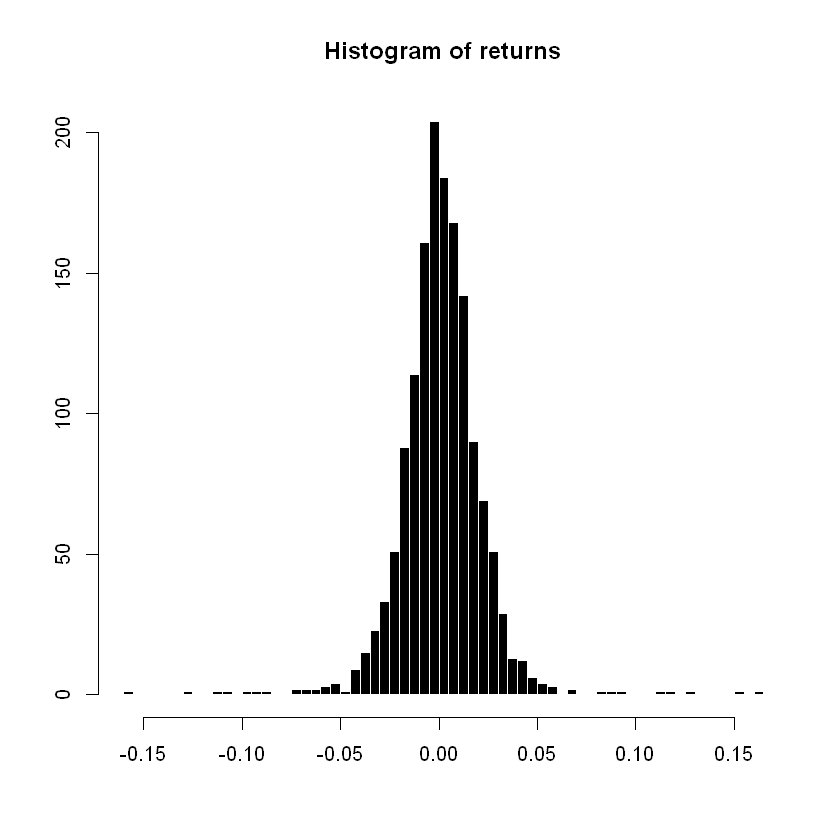

In [4]:
#Skewness
print(paste("Skewness of returns: ", round(skewness(amzn$ret), 2)))
#Kurtosis
print(paste("Kurtosis of returns: ", round(kurtosis(amzn$ret), 2)))
#Normality
jarque.bera.test(amzn$ret)
#Histogram
hist(amzn$ret, breaks = "FD", border = F, main = "Histogram of returns", col = "black", xlab = "", ylab = "")
#Stationarity
adf.test(amzn$ret)

The results above suggest that the distribution of returns is indeed far from normal. The skewness is nearly zero and the kurtosis is very high. This is also visible from the histogram of returns which shows that their distribution has heavy tails. Therefore, it might be reasonable to assume that the returns follow a t-distribution rather than normal (The Jarque-Bera test rejects the null of normality). On the other hand, the Augmented Dickey-Fuller test rejects the null hypothesis of the series containing a unit root in favor of the alternative of stationarity. We can confirm these findings by looking at the plots.

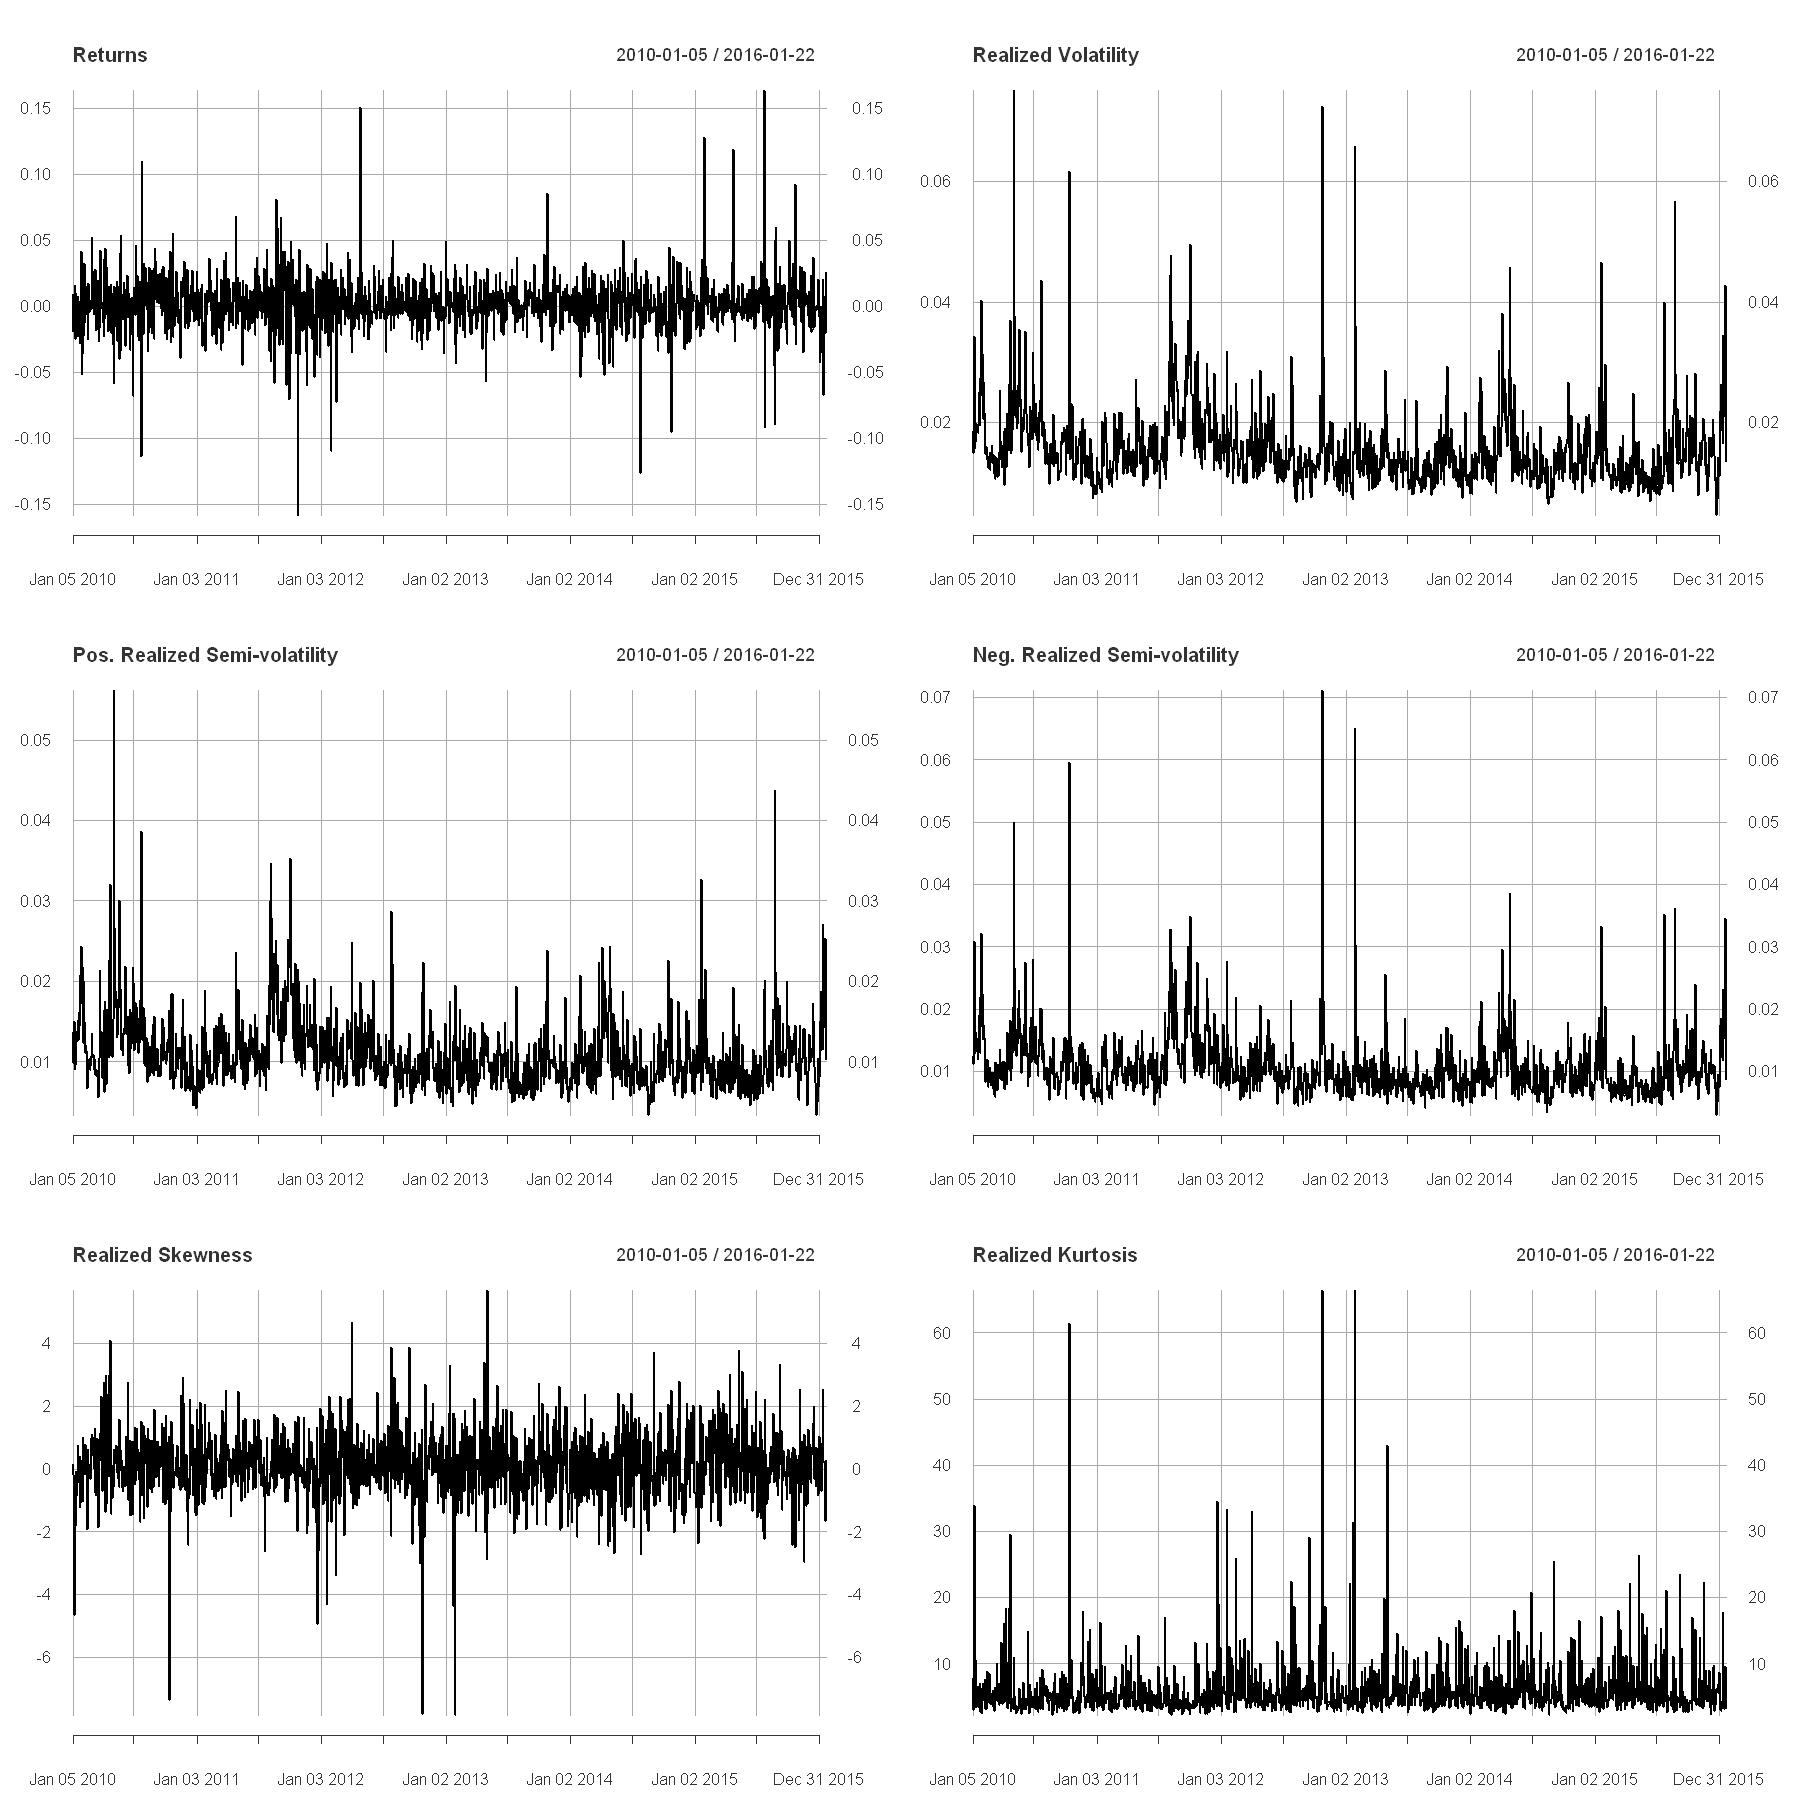

In [5]:
#Basic plots
options(repr.plot.width = 15, repr.plot.height = 15)
plot_names <- c("Returns", "Realized Volatility", "Pos. Realized Semi-volatility", "Neg. Realized Semi-volatility", "Realized Skewness", "Realized Kurtosis")
par(mfrow = c(3, 2))
for (i in 1:6) {
  print(plot(amzn[, i], main = plot_names[i]))
}

From the plot of the return series it appears that the returns are indeed mean-stationary. However, we can observe some variance clustering. For illustration purposes, we also present some plots combining the returns with Realized Volatility and also a plot with both Semi-volatilities.

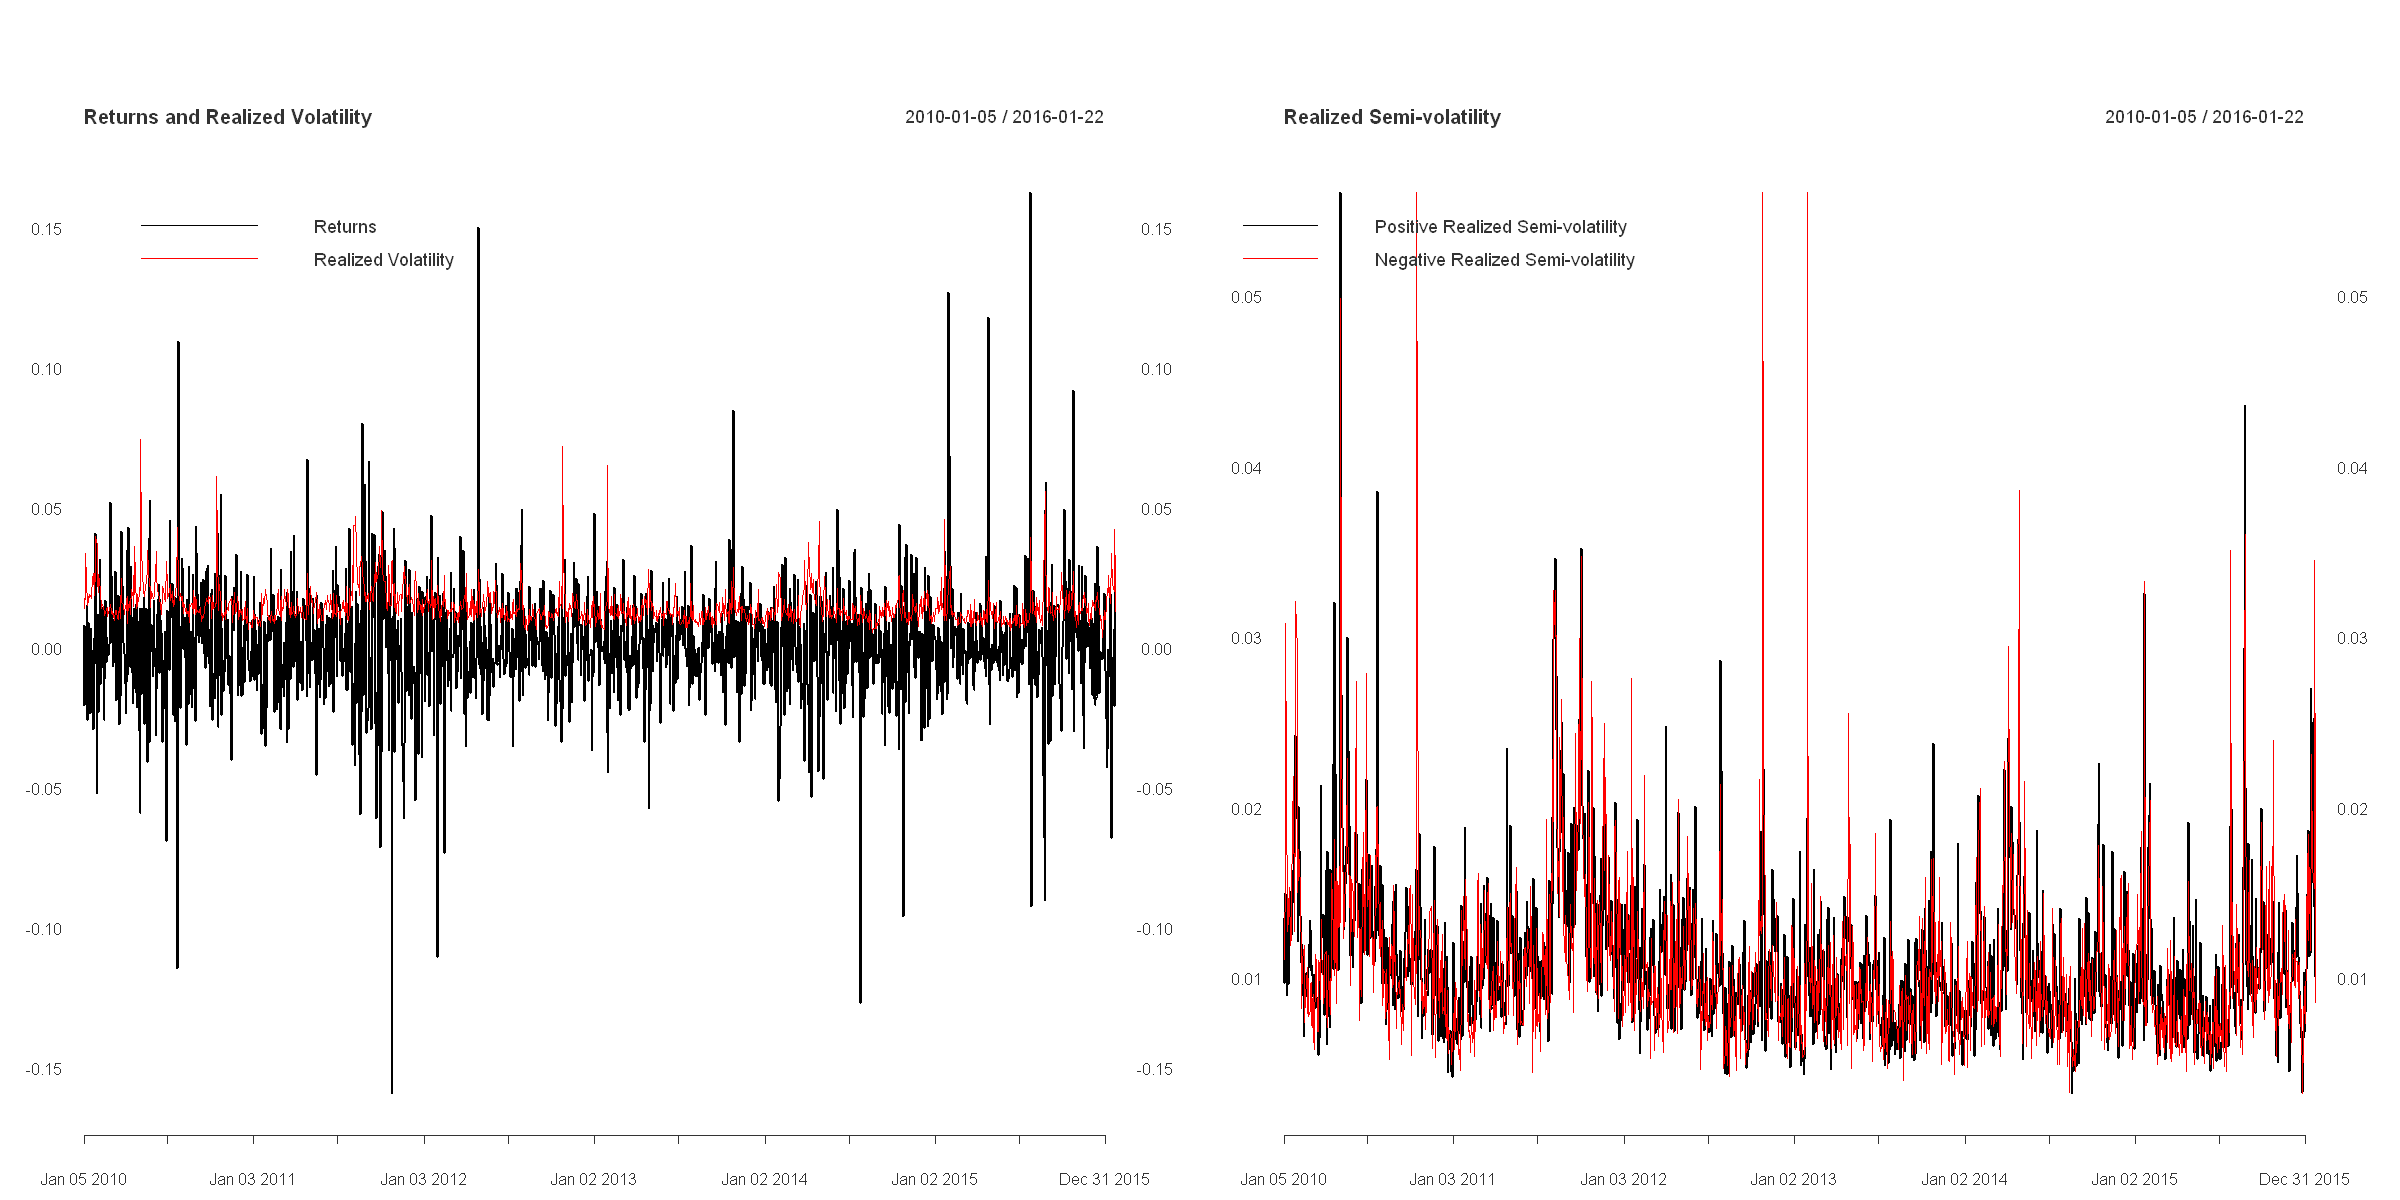

In [6]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1, 2))
#Returns and Realized Volatility
plot_holder <- plot(amzn$ret, main = "Returns and Realized Volatility", grid.col = NA)
plot_holder <- lines(amzn$RV, col = "red")
plot_holder <- addLegend("topleft", on = 1, legend.names = c("Returns", "Realized Volatility"), col = c("black", "red"), lty = 1, bty = "n")
plot_holder
#Positive and negative realized semi-volatility
plot_holder <- plot(amzn$RV_p, main = "Realized Semi-volatility", grid.col = NA)
plot_holder <- lines(amzn$RV_n, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Positive Realized Semi-volatility", "Negative Realized Semi-volatility"), col = c("black", "red"), lty = 1, bty = "n")
plot_holder

In the next step, we will inspect the dependencies in each series by calculating the Autocorrelation Function (ACF) and the Partial Autocorrelation function (PACF).

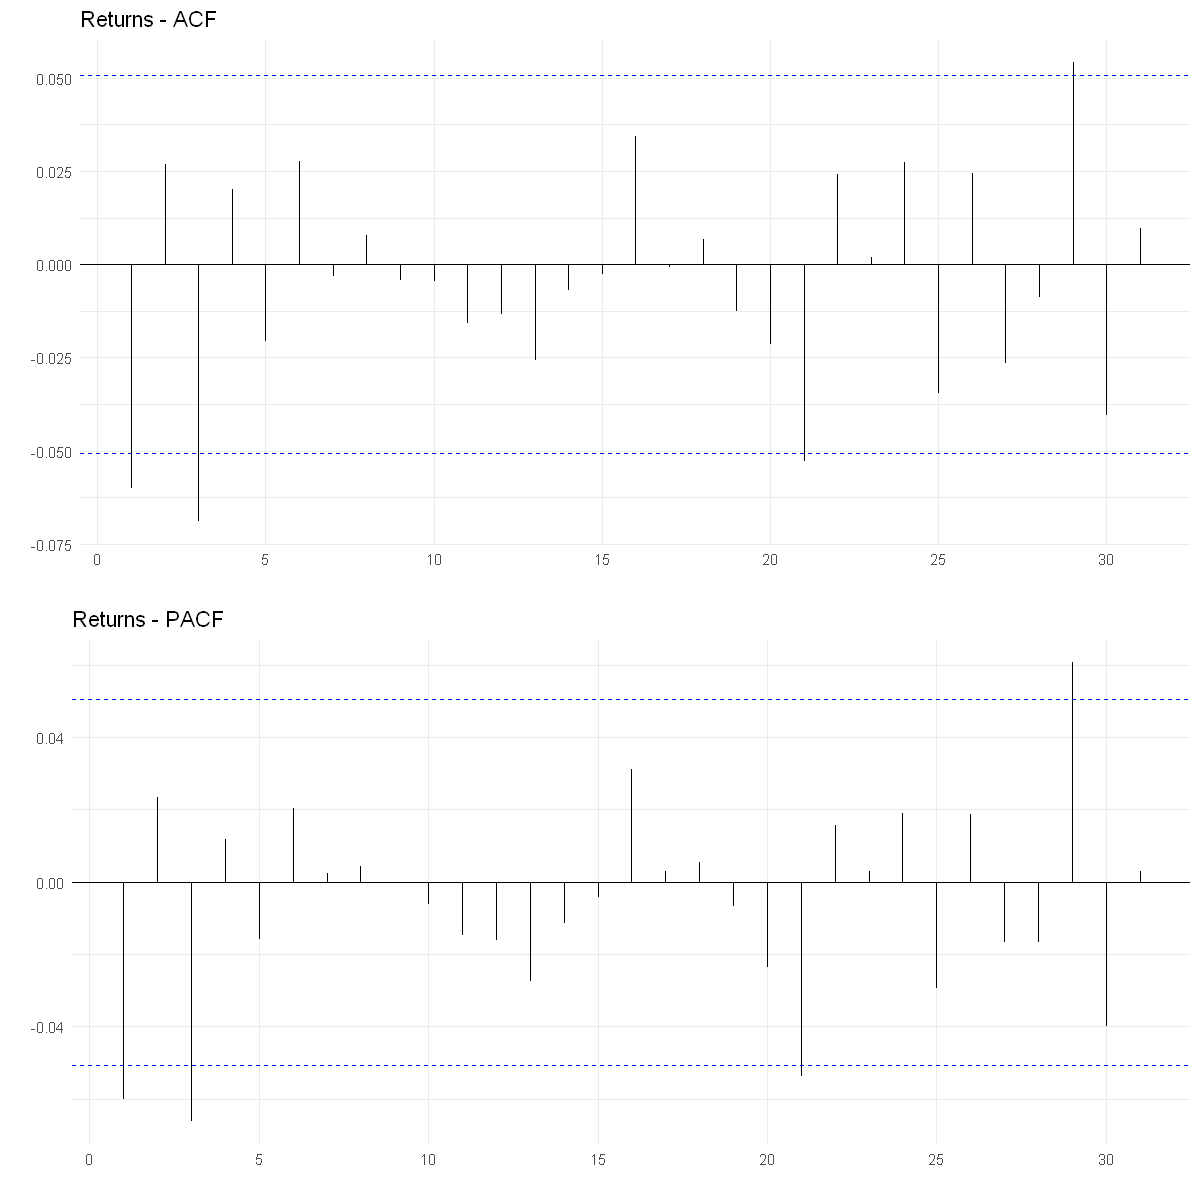

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)
#ACF and PACF for returns
acf_ret <- ggAcf(amzn$ret)+
  theme_minimal()+
  ggtitle("Returns - ACF")+
  ylab("")+
  xlab("")
pacf_ret <- ggPacf(amzn$ret)+
  theme_minimal()+
  ggtitle("Returns - PACF")+
  ylab("")+
  xlab("")
ggarrange(acf_ret, pacf_ret, ncol = 1, nrow = 2)

We can see that there are some significant autocorrelations which is something we will keep in mind during ARMA modelling.

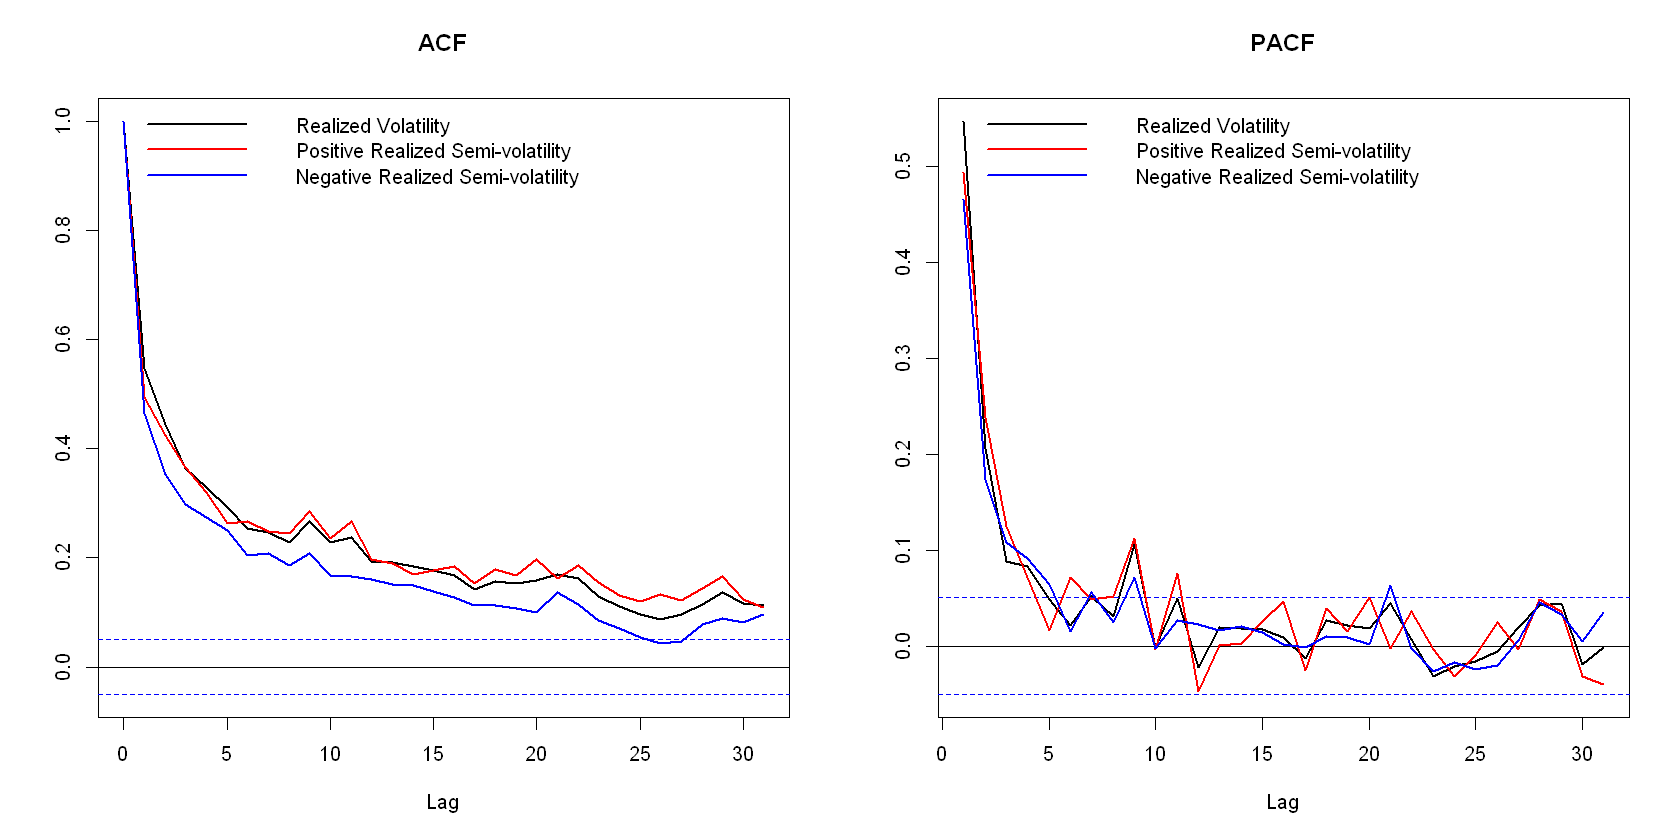

In [8]:
options(repr.plot.width = 14, repr.plot.height = 7)
par(mfrow = c(1, 2))
#ACF for Realized Volatility
acf_RV <- acf(amzn$RV, plot = F)
acf_RV_p <-  acf(amzn$RV_p, plot = F)
acf_RV_n <-  acf(amzn$RV_n, plot = F)
plot(acf_RV, type = "l", main = "ACF", ylab = "", lwd = 2)
lines(x = acf_RV_p$lag, y = acf_RV_p$acf, col = "red", lwd = 2)
lines(x = acf_RV_n$lag, y = acf_RV_n$acf, col = "blue", lwd = 2)
legend("topleft", legend = c("Realized Volatility", "Positive Realized Semi-volatility", "Negative Realized Semi-volatility"), col = c("black", "red", "blue"), bty = "n", lty = 1, lwd = 2)
#PACF
pacf_RV <- pacf(amzn$RV, plot = F)
pacf_RV_p <-  pacf(amzn$RV_p, plot = F)
pacf_RV_n <-  pacf(amzn$RV_n, plot = F)
plot(pacf_RV, type = "l", main = "PACF", ylab = "", lwd = 2)
lines(x = pacf_RV_p$lag, y = pacf_RV_p$acf, col = "red", lwd = 2)
lines(x = pacf_RV_n$lag, y = pacf_RV_n$acf, col = "blue", lwd = 2)
legend("topleft", legend = c("Realized Volatility", "Positive Realized Semi-volatility", "Negative Realized Semi-volatility"), col = c("black", "red", "blue"), bty = "n", lty = 1, lwd = 2)

The figure above shows the ACF for Realized Volatility and Semi-volatilities. The results suggests that all three series are strongly autocorrelated. The line representing Negative Realized Semi-volatility is below the other two suggesting that it is slightly less dependent. Since the autocorrelations are initially very high and then they dissipate expontentially with increasing lags, we could argue that the Realized volatility may follow some form of an Autoregressive proccess, for example, AR(1) with a coefficient on the lagged term being quite low in magnitude.

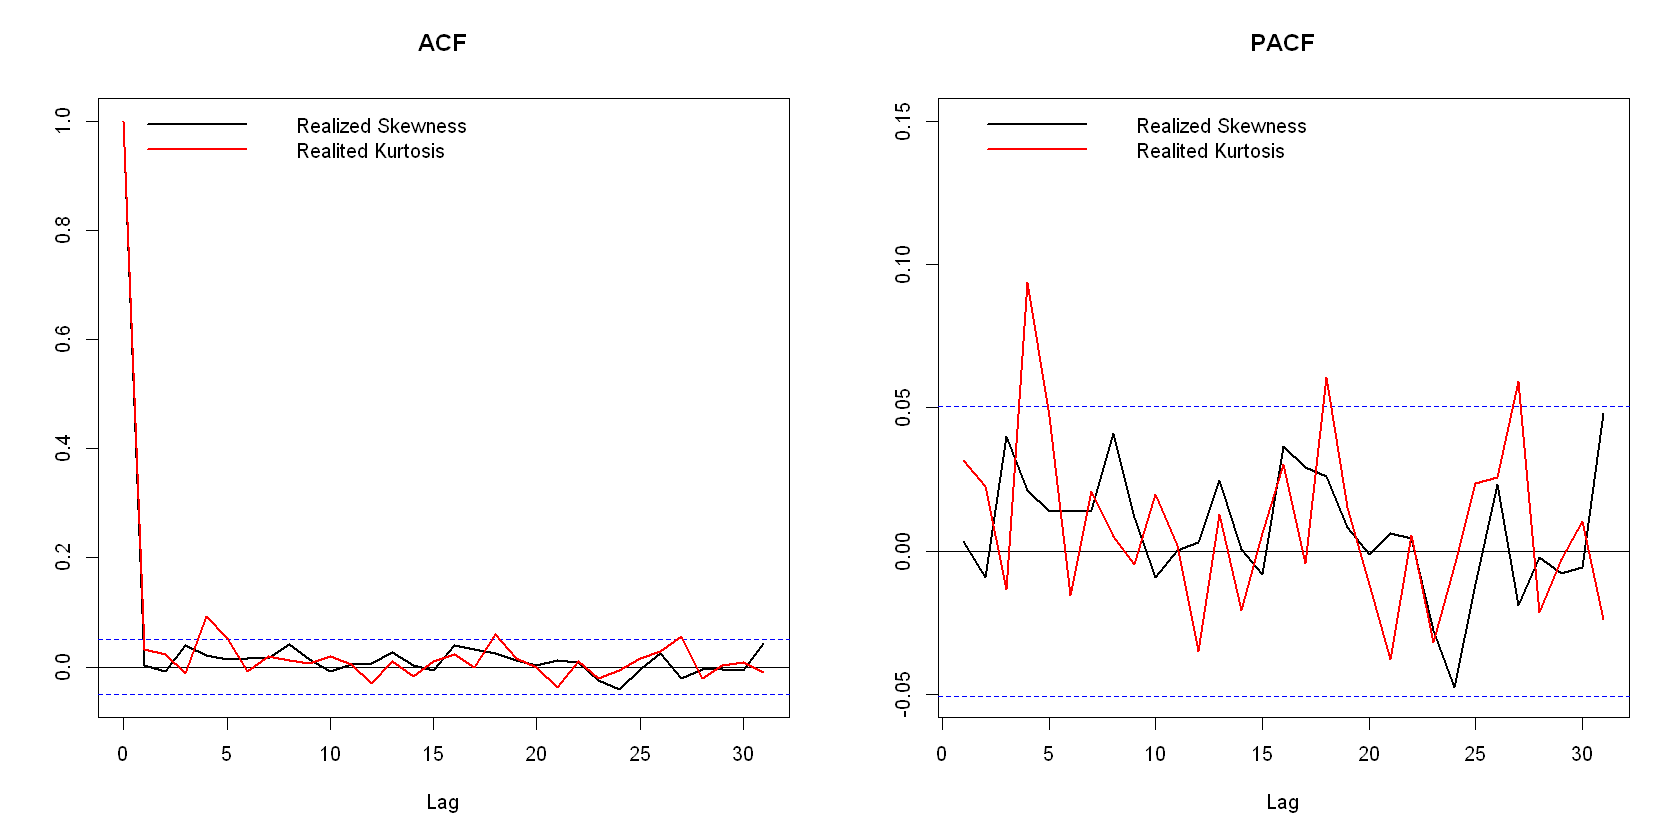

In [29]:
options(repr.plot.width = 14, repr.plot.height = 7)
par(mfrow = c(1, 2))
#ACF for Realized Skewness and Kurtosis
acf_RS <- acf(amzn$RS, plot = F)
acf_RK <-  acf(amzn$RK, plot = F)
plot(acf_RS, type = "l", main = "ACF", ylab = "", lwd = 2)
lines(x = acf_RK$lag, y = acf_RK$acf, col = "red", lwd = 2)
legend("topleft", legend = c("Realized Skewness", "Realited Kurtosis"), col = c("black", "red"), bty = "n", lty = 1, lwd = 2)
#PACF
pacf_RS <- pacf(amzn$RS, plot = F)
pacf_RK <-  pacf(amzn$RK, plot = F)
plot(pacf_RS, type = "l", main = "PACF", ylab = "", lwd = 2, ylim = c(-0.05, 0.15))
lines(x = pacf_RK$lag, y = pacf_RK$acf, col = "red", lwd = 2)
legend("topleft", legend = c("Realized Skewness", "Realited Kurtosis"), col = c("black", "red"), bty = "n", lty = 1, lwd = 2)

As for Realized Skewness, there appear to be no significant dependencies. In case of Realized Kurtosis, there seem to be significant dependencies in 4th, 19th, and 28th lag, however in magnitude they barely exceed the 95% confidenece interval, suggesting only marginal dependency.

### 2. In-sample fit

In this section, we estimate 6 models in total on the provided data and inspect the differences between in-sample fits.

#### Realized Volatility - AR(1)

The first model is a simple autoregressive process which takes the following form:
$$
RV_t = \alpha + \beta RV_{t-1} + \epsilon_t,
$$
where $RV_t$ is Realized Volatility and $\epsilon_t \sim N(0,\sigma^2)$.

In [30]:
#Realized Volatility - AR(1)
amzn$RV_lag <- lag(amzn$RV) #Adding the first lag of RV to the data
ar1_rv <- lm(RV ~ RV_lag, data = amzn) #OLS estimation
summary(ar1_rv)


Call:
lm(formula = RV ~ RV_lag, data = amzn)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.026926 -0.002979 -0.000668  0.001815  0.057279 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0070328  0.0003632   19.36   <2e-16 ***
RV_lag      0.5469940  0.0216356   25.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005336 on 1497 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.2992,	Adjusted R-squared:  0.2988 
F-statistic: 639.2 on 1 and 1497 DF,  p-value: < 2.2e-16


As we can see, the coefficient on the lag is highly statistically significant. Considering the magnitude of the coefficient, Realized Volatility does not appear to be highly persistent. The Adjusted R-squared is quite high as well which signals a decent fit. We can now plot the fitted values and compare them to observed values. 

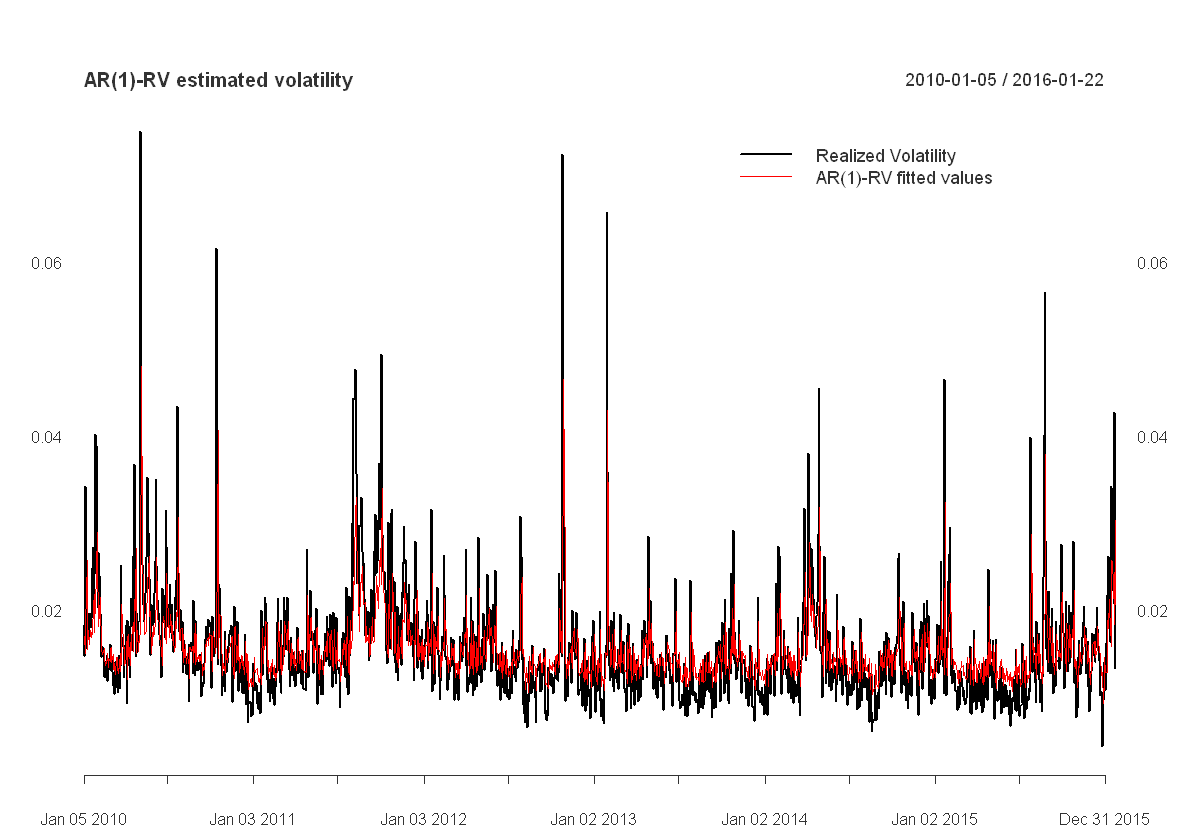

In [31]:
options(repr.plot.width = 10, repr.plot.height = 7)
#Plotting fitted values
ar1_fitted <- xts(fitted.values(ar1_rv), order.by = as.Date(names(fitted.values(ar1_rv))))
plot_holder <- plot(amzn$RV, main = "AR(1)-RV estimated volatility", grid.col = NA)
plot_holder <- lines(ar1_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "AR(1)-RV fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

The predictions seem to fit the data quite well. However, there are some large jumps in Realized Volatility that the model fails to capture. In addition, the Realized Volatility appears to be systematically overestimated.

#### Heterogenous Autoregressive Model (HAR)

The second model we are going to estimate extends the previous one by including the weekly and monthly effects. It takes the following form:
$$
RV_t = \alpha + \beta_1RV_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + \epsilon_t,
$$
where $RV_t$ is the Realized Volatility, $RV_{t-1}^{(h)}=\frac{1}{h}\sum_{i=1}^hRV_{t-i}$, and $\epsilon_t\sim N(0,\sigma^2)$.

Firstly, we will estimate the model using the function ``HARmodel`` function from the ``highfrequency`` package. Subsequently, we will verify the results by manual estimation.

In [32]:
#Automatic estimation
har_auto <- HARmodel(amzn$RV, periods = c(1, 5, 22))
summary(har_auto)
har_fitted <- xts(har_auto$fitted.values, order.by = as.Date(names(har_auto$fitted.values))) #Store the fitted values


Call:
"RV1 = beta0  +  beta1 * RV1 +  beta2 * RV5 +  beta3 * RV22"

Residuals:
      Min        1Q    Median        3Q       Max 
-0.020618 -0.002741 -0.000754  0.001617  0.056728 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
beta0 0.003064   0.000581   5.273 1.54e-07 ***
beta1 0.348454   0.051340   6.787 1.65e-11 ***
beta2 0.250959   0.066139   3.794 0.000154 ***
beta3 0.201317   0.054665   3.683 0.000239 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005141 on 1474 degrees of freedom
Multiple R-squared:  0.3334,	Adjusted R-squared:  0.332 
F-statistic: 245.7 on 3 and 1474 DF,  p-value: < 2.2e-16


As we can see, all of the terms are highly statistically significant. The Adjusted R-squared is higher than in the previous model which suggests that we get improved predictions by accounting for the weekly and monthly effects. Let us now try to manually replicate the results.

In [33]:
#Manual estimation
calc_HAR_term <- function (x, len) { #Function for calculating HAR terms based on length
  result <- xts(rep(NA, length(x)), order.by = index(x)) #Empty xts object for the results
  for (i in len:length(x)) { #We have to skip the first "len - 1" observations
    result[i] <- mean(x[(i - len + 1):i], na.rm = T) #For each obs calculate the mean of past "len - 1" observations
  }
  return(as.numeric(lag(result))) #Return a lag of the resulting series as a vector
}
amzn$RV_5 <- calc_HAR_term(amzn$RV, 5) #RV_(t-1)^5
amzn$RV_22 <- calc_HAR_term(amzn$RV, 22) #RV_(t-1)^22
har_manual <- lm(RV ~ RV_lag + RV_5 + RV_22, data = amzn)
coeftest(har_manual, vcov = NeweyWest(har_manual, lag = 22)) #HAC Newey-West standard errors to match the auto function


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 0.00306412 0.00058105  5.2735 1.538e-07 ***
RV_lag      0.34845370 0.05134044  6.7871 1.653e-11 ***
RV_5        0.25095893 0.06613889  3.7944 0.0001540 ***
RV_22       0.20131701 0.05466504  3.6827 0.0002391 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


The results of the manual estimation are identical to those obtained with the ``HARmodel`` function. To replicate the standard errors we calculated the Heteroskedasticity and Autocorrelation Covariance matrix proposed by Newey and West (1987). We can now plot the fitted values to inspect the in-sample fit.

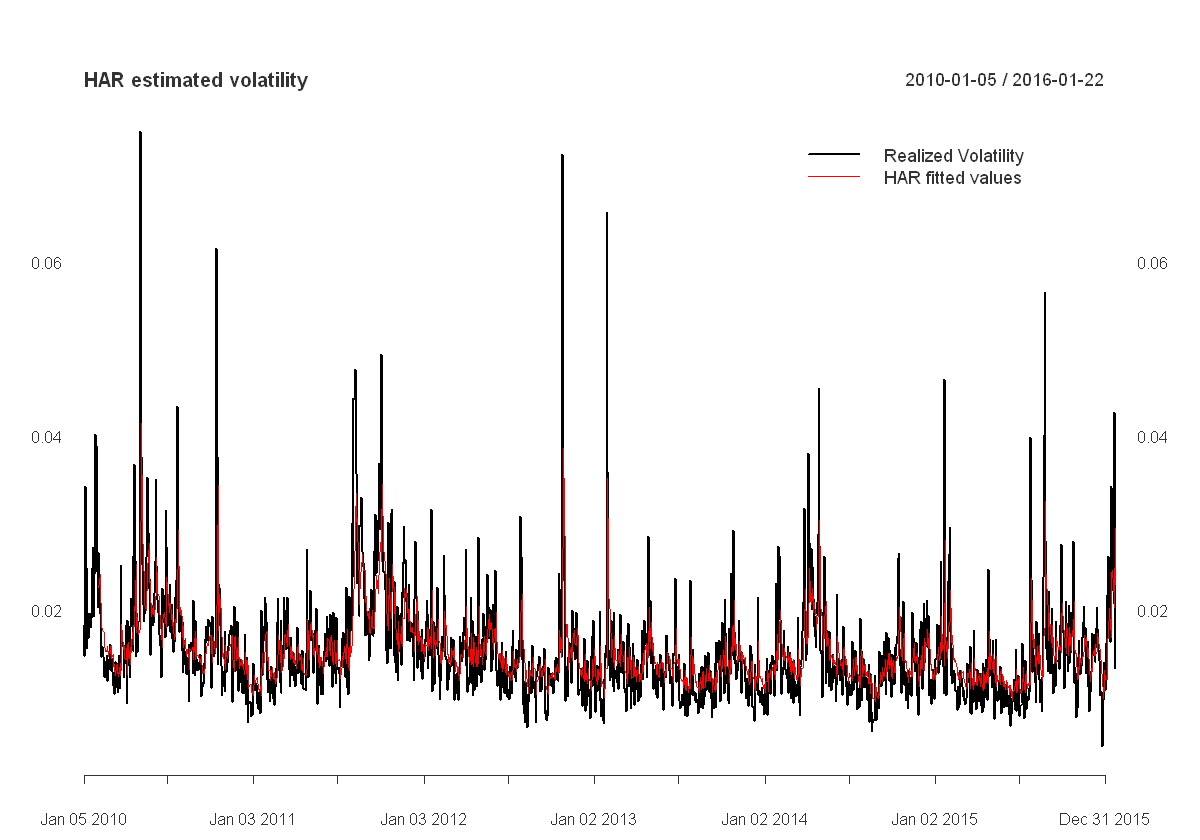

In [34]:
#Plotting fitted
plot_holder <- plot(amzn$RV, main = "HAR estimated volatility", grid.col = NA)
plot_holder <- lines(har_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "HAR fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

The fit appears to be similar to the previous model, however, we would expect some improvements. We will inspect the differences in a direct comparison later.

#### HAR with Realized Semi-Volatility (HAR-RS)

The third considered model extends HAR by accounting for the asymmetric effect of positive and negative realized volatility. It takes the following form:
$$
RV_t = \alpha + \beta_1^+RS^+_{t-1} + \beta_1^-RS^-_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + \epsilon_t,
$$
where $RS^+_{t-1}$ and $RS^-_{t-1}$ is the Positive and Negative Realized Semi-Volatility, respectively.

In [35]:
#HAR-RS
amzn$RV_p_lag <- lag(amzn$RV_p) #Lag of Realized Positive Semi-Volatility
amzn$RV_n_lag <- lag(amzn$RV_n) #Lag of Realized Negative Semi-Volatility
har_rs <- lm(RV ~ RV_p_lag + RV_n_lag + RV_5 + RV_22, data = amzn)
summary(har_rs)
har_rs_fitted <- xts(har_rs$fitted.values, order.by = as.Date(names(har_rs$fitted.values)))


Call:
lm(formula = RV ~ RV_p_lag + RV_n_lag + RV_5 + RV_22, data = amzn)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.022152 -0.002728 -0.000734  0.001694  0.056346 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0030913  0.0005896   5.243 1.81e-07 ***
RV_p_lag    0.1600690  0.0452732   3.536 0.000419 ***
RV_n_lag    0.3454031  0.0369188   9.356  < 2e-16 ***
RV_5        0.2421263  0.0506247   4.783 1.90e-06 ***
RV_22       0.2043427  0.0529524   3.859 0.000119 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005119 on 1473 degrees of freedom
  (22 observations deleted due to missingness)
Multiple R-squared:  0.3393,	Adjusted R-squared:  0.3375 
F-statistic: 189.1 on 4 and 1473 DF,  p-value: < 2.2e-16


The model summary above shows that in line with the literature, Negative Realized Semi-Volatility appears to have a larger impact on Realized Volatility than Positive. The magnitude of the estimated coefficient is in fact more than two times larger. It does not seem to hold that $\widehat{\beta_1^+} = \widehat{\beta_1^-} = \widehat{\beta_1}$ (where $\widehat{\beta_1}$ comes from the prevous model), which confirms that we brought new information into the model by decomposing the Realized Volatility. To further show that the effects of the Semi-Volatilities are assymetric, we test the hypothesis that $\widehat{\beta_1^+} - \widehat{\beta_1^-} = 0$.

In [36]:
#Testing a linear restriction hypothesis
summary(lm(RV ~ I(RV_p_lag - RV_n_lag) + RV_5 + RV_22, data = amzn))


Call:
lm(formula = RV ~ I(RV_p_lag - RV_n_lag) + RV_5 + RV_22, data = amzn)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.016714 -0.002838 -0.000782  0.001649  0.056984 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.0035672  0.0006113   5.836 6.58e-09 ***
I(RV_p_lag - RV_n_lag) -0.1742535  0.0347790  -5.010 6.09e-07 ***
RV_5                    0.5757088  0.0420558  13.689  < 2e-16 ***
RV_22                   0.1942431  0.0550421   3.529  0.00043 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005322 on 1474 degrees of freedom
  (22 observations deleted due to missingness)
Multiple R-squared:  0.2854,	Adjusted R-squared:  0.2839 
F-statistic: 196.2 on 3 and 1474 DF,  p-value: < 2.2e-16


As the results suggest, the difference is statistically different from zero and therefore we reject the null hypothesis of a symmetric effect. We now proceed to plot the fitted values.

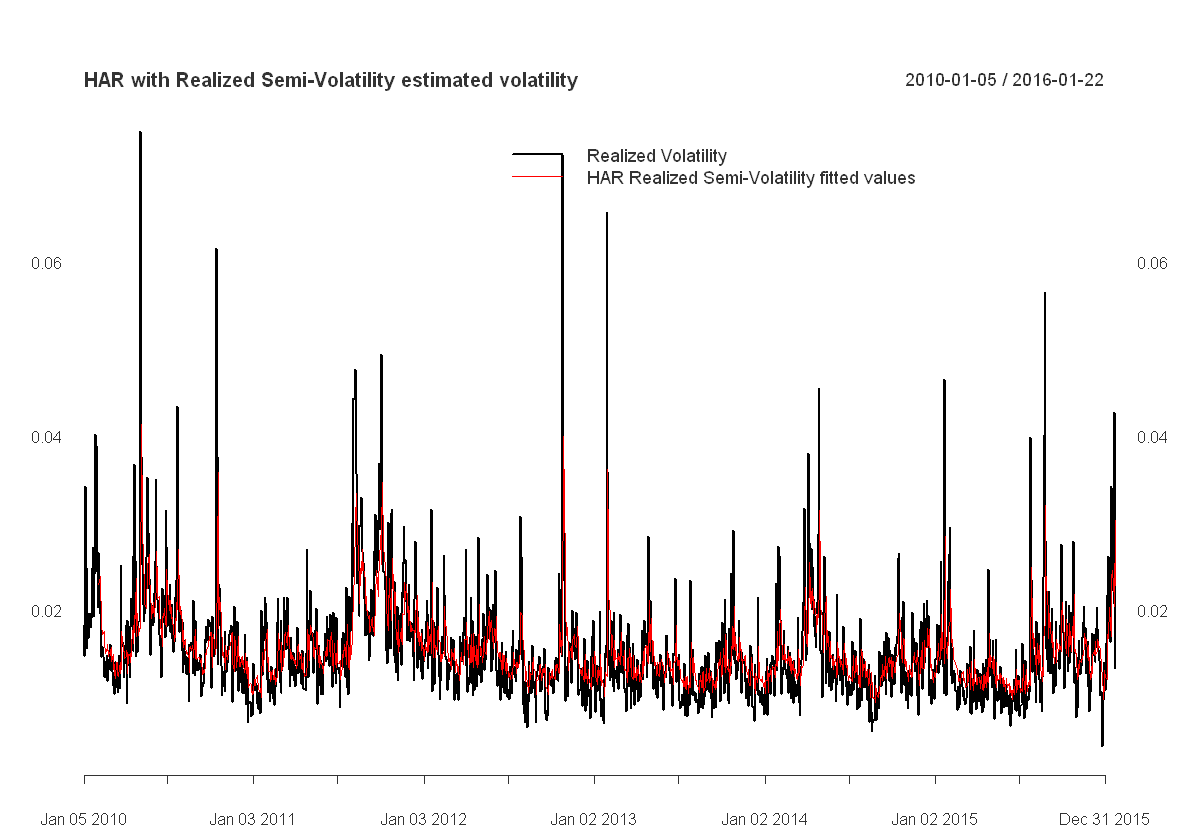

In [38]:
#Plotting fitted values
plot_holder <- plot(amzn$RV, main = "HAR with Realized Semi-Volatility estimated volatility", grid.col = NA)
plot_holder <- lines(har_rs_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "HAR Realized Semi-Volatility fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

The in-sample fit appears to be similar as in the previous two models. We can still see that the Realized Volatility is systematically overestimated.

#### HAR with Realized Skewness and Realized Kurtosis (HAR-Rskew-RKurt)

The last extension of HAR that we are going to estimate is adding Realized Skewness and Realized Kurtosis into the model equation. These higher moments may contain important information that will help in predicting Realized Volatility. The model is specified as follows:
$$
RV_t = \alpha + \beta_1RV_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + \beta_4RSkew_{t-1} + \beta_5RKurt_{t-1} + \epsilon_t,
$$
where $RSkew_{t-1}$ and $RKurt_{t-1}$ are Realized Skewness and Realized Kurtosis, respectively.

In [39]:
#HAR-Rskew-RKurt
amzn$RS_lag <- lag(amzn$RS) #Lag of Realized Skewness
amzn$RK_lag <- lag(amzn$RK) #Lag of Realized Kurtosis
har_skew_kurt <- lm(RV ~ RV_lag + RV_5 + RV_22 + RS_lag + RK_lag, data = amzn)
summary(har_skew_kurt)
har_skew_kurt_fitted <- xts(har_skew_kurt$fitted.values, order.by = as.Date(names(har_skew_kurt$fitted.values)))


Call:
lm(formula = RV ~ RV_lag + RV_5 + RV_22 + RS_lag + RK_lag, data = amzn)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.014158 -0.002722 -0.000727  0.001700  0.058431 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.329e-03  6.205e-04   6.977 4.54e-12 ***
RV_lag       4.181e-01  3.283e-02  12.736  < 2e-16 ***
RV_5         2.084e-01  5.030e-02   4.144 3.61e-05 ***
RV_22        1.665e-01  5.284e-02   3.151  0.00166 ** 
RS_lag      -1.651e-04  1.226e-04  -1.346  0.17837    
RK_lag      -1.881e-04  3.165e-05  -5.943 3.49e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00508 on 1472 degrees of freedom
  (22 observations deleted due to missingness)
Multiple R-squared:   0.35,	Adjusted R-squared:  0.3478 
F-statistic: 158.5 on 5 and 1472 DF,  p-value: < 2.2e-16


As we can see, Realized Skewness does not appear to have a significant effect on Realized Volatility. Nevertheless, Realized Kurtosis is highly statistically significant and the Adjusted R-Squared is the highest among the models considered so far. In addition, the coefficient is negative indicating that high kurtosis in the previous period decreases volatility in the current period. The plot of the fitted values follows.

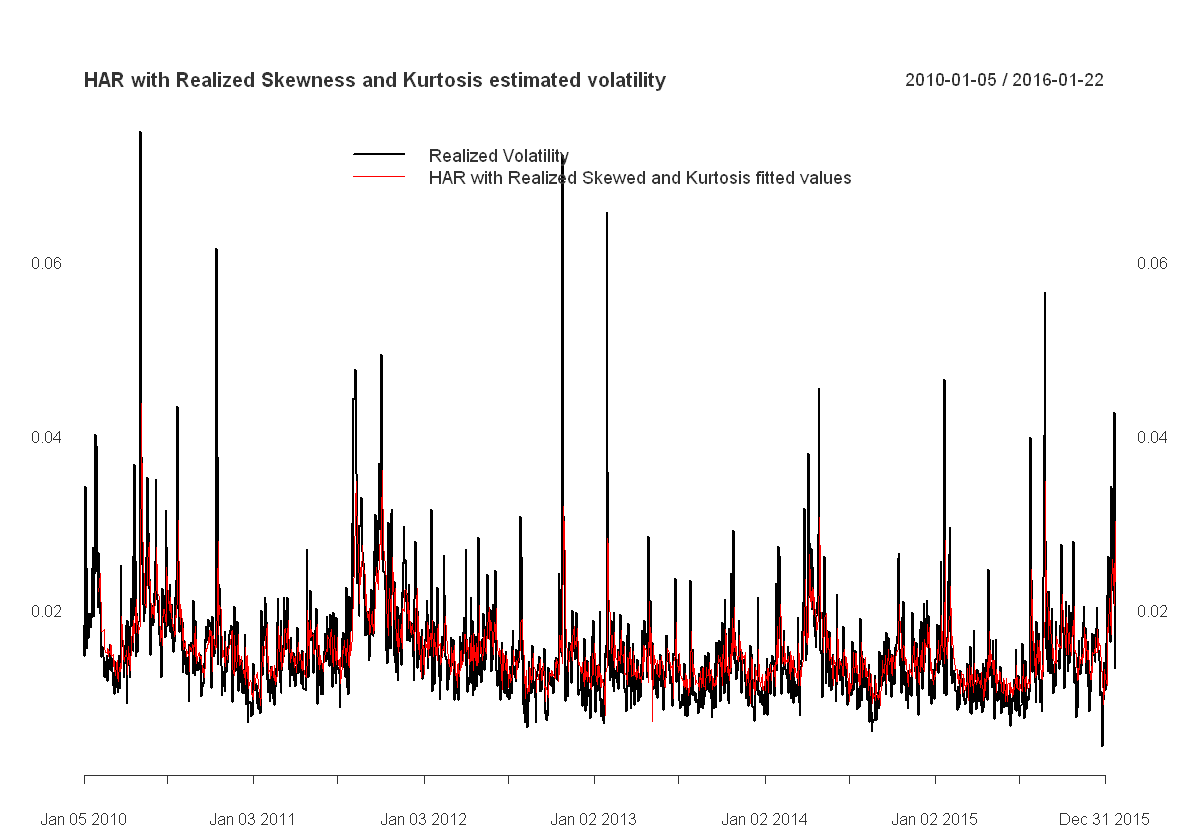

In [41]:
#Plotting fitted values
plot_holder <- plot(amzn$RV, main = "HAR with Realized Skewness and Kurtosis estimated volatility", grid.col = NA)
plot_holder <- lines(har_skew_kurt_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "HAR with Realized Skewed and Kurtosis fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

Once again, the plot appears to be similar to previous models. However, we could argue that the systematic underestimation of Realized Volatility is slightly less pronounced.

#### Realized GARCH

Moving away from HAR, the next model we will estimate is the Realized GARCH. It is an extension of a simple GARCH model which estimates the conditional variance of the underlying returns. In Realized GARCH, the Realized Volatility is added since it may help in predicting the conditional volatility and should improve the fit. The Realized GARCH(1,1) model takes the following form and is estimated by the Quasi-Maximum Likelihood Estimator (QMLE):
$$
\begin{gather*} 
r_t = z_t\sqrt{h_t} \\
log(h_t) = \omega + \alpha_1log(RV_{t-1}) + \beta_1log(h_{t-1}) \\
log(RV_t) = \xi + \delta log(h_t) + u_t,
\end{gather*} 
$$
where $r_t$ are the returns, $z_t\sim N(0,1)$, and $u_t\sim N(0, \sigma^2)$.


In [42]:
#Realized GARCH
real_garchspec <- ugarchspec(variance.model = list(model = "realGARCH", garchOrder = c(1, 1)),
                            mean.model = list(armaOrder = c(0, 0)), distribution.model = "std")
real_garch_fit<- ugarchfit(real_garchspec, amzn$ret, realizedVol = amzn$RV)  
real_garch_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000951    0.000394  2.41649 0.015671
omega   0.083454    0.341122  0.24465 0.806731
alpha1  1.000000    0.109619  9.12248 0.000000
beta1   0.482208    0.037398 12.89381 0.000000
eta11  -0.048391    0.006341 -7.63131 0.000000
eta21   0.015754    0.001723  9.14513 0.000000
delta   0.392662    0.033340 11.77764 0.000000
lambda  0.243929    0.004469 54.58778 0.000000
shape   4.920030    0.546343  9.00539 0.000000
xi     -1.085886    0.265790 -4.08550 0.000044

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000951    0.000361  2.63347 0.008452
omega   0.083454    0.340462  0.24512 0.806363
alpha1

The estimation results are available above. The majority of the coefficients are statistically significant with the exception of the intercept in the equation for conditional variance. The specification tests suggest that there should not be any dependencies in the standardized residuals. We can confirm that by looking at the ACF and PACF. In addition, as mentioned above, we assumed that the returns follow a Student's t-distribution. The shape parameter is highly statistically significant and suggests approximately 5 degrees of freedom.

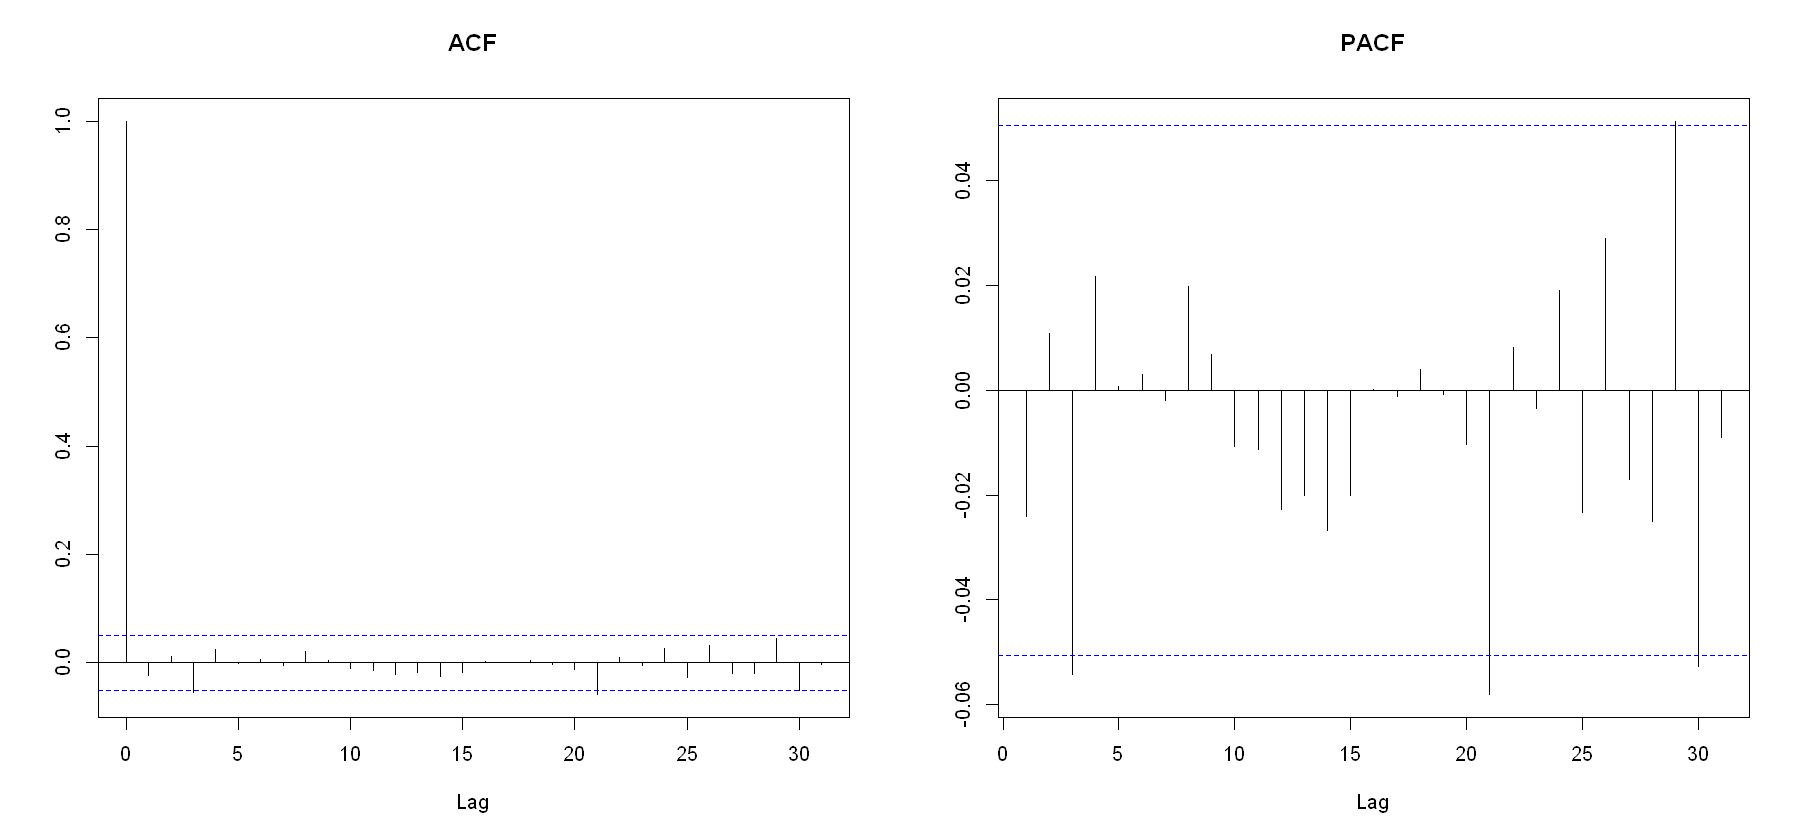

In [43]:
options(repr.plot.width = 15, repr.plot.height = 7)
#ACF and PACF of standardized residuals
par(mfrow = c(1, 2))
acf(residuals(real_garch_fit, standardize = T), main = "ACF", ylab = "")
pacf(residuals(real_garch_fit, standardize = T), main = "PACF", ylab = "")

The PACF shows some very small dependencies in the standardized residuals, however, given the unpredictive nature of real world data, we deem the results satisfactory. In addition, since our aim is forecasting, we want our model to be as parsimonious as possible to avoid overfitting. In the next step, we will investigate how well the estimated conditional volatility fits the actual values of Realized Volatility.

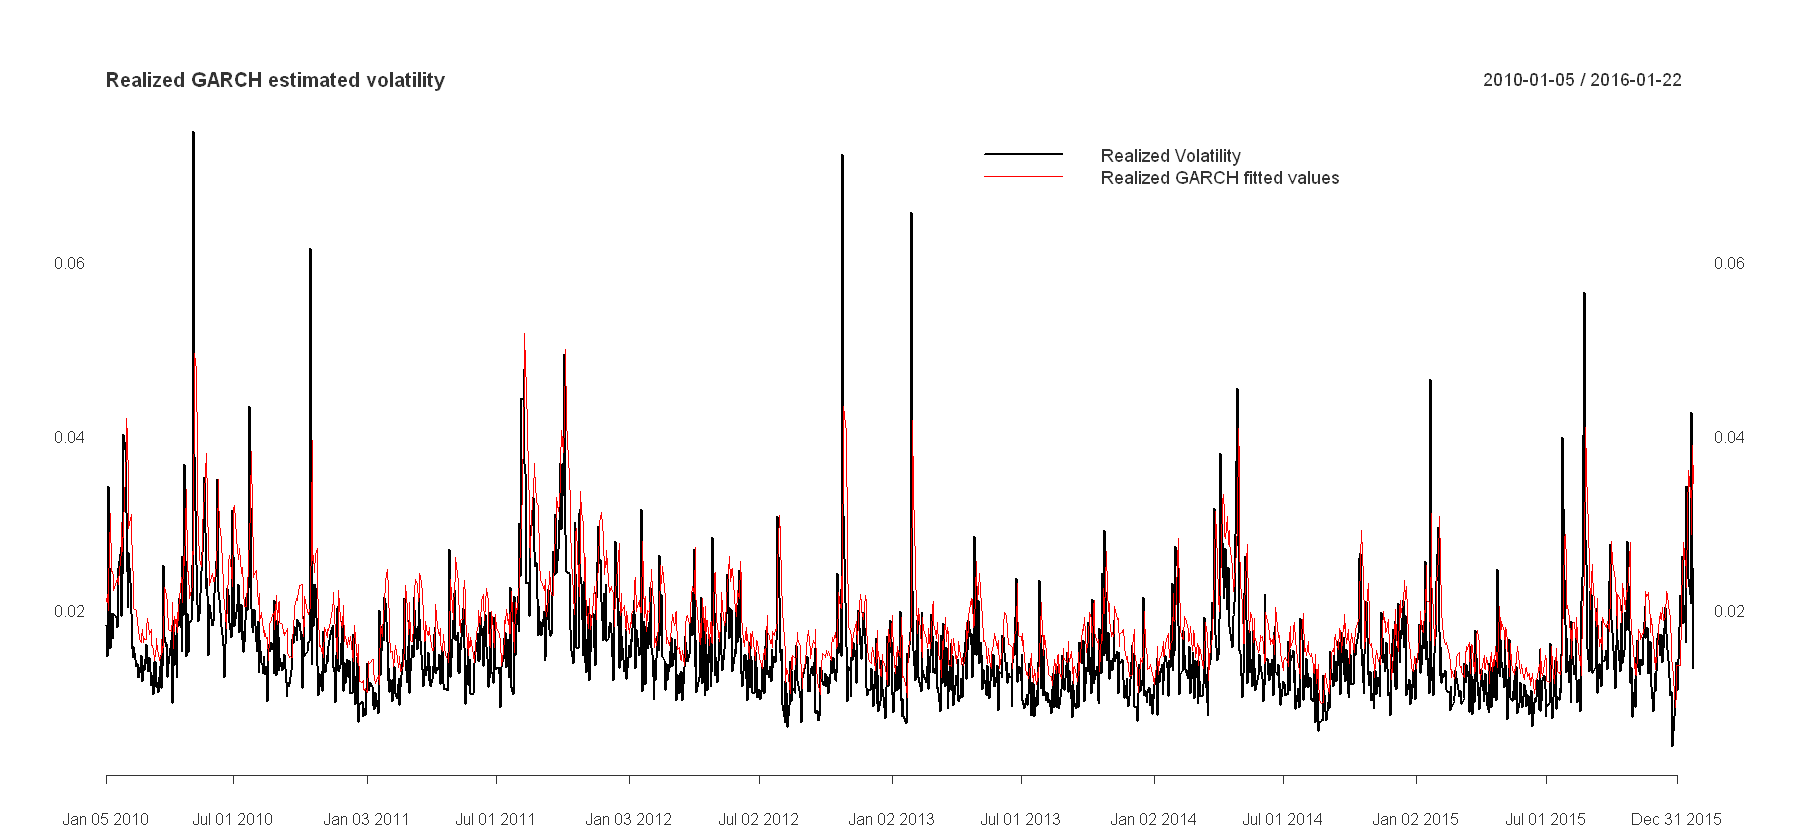

In [44]:
#Plotting the estimated conditional volatility
real_garch_fitted <- sigma(real_garch_fit)
plot_holder <- plot(amzn$RV, main = "Realized GARCH estimated volatility", grid.col = NA)
plot_holder <- lines(real_garch_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "Realized GARCH fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

As we can see, the conditional volatility appears to heavily overestimate the values of Realized Volatility.

#### ARMA-GARCH

The last model is a simple GARCH model with ARMA modelled returns. A general ARMA(m,n)-GARCH(p,q) model takes the following form and is estimated using the Maximum Likelihood Estimator (MLE):
$$
\begin{gather*} 
r_t = \mu + \sum_{i=1}^m\theta_ir_{t-i} + \sum_{i=1}^n\delta_iu_{t-i} + u_t 
\\
u_t=\sqrt{h_t}\epsilon_t \\
h_t = \omega + \sum_{i=1}^p\alpha_iu_{t-i}^2 + \sum_{i=1}^q\beta_ih_{t-i},
\end{gather*} 
$$
where $\epsilon_t\sim N(0,1)$.

When estimating ARMA-GARCH, one has to first find the appropriate ARMA model for the returns. In Section 1 we observed some significant dependencies in the series of returns. Therefore, we will try to find a suitable model by minimizing the information criteria.

In [45]:
#Minimizing the information criteria
for (inf_crit in c("aic","aicc","bic")) {
        auto_model <- auto.arima(amzn$ret, stationary = T, ic = inf_crit) 
        print(paste(inf_crit, ": ", "ARMA(", auto_model$arma[1], ",", auto_model$arma[2], ")", sep = ""), quote = F)
    }

[1] aic: ARMA(1,1)
[1] aicc: ARMA(1,1)
[1] bic: ARMA(0,0)


As we can see, the Akaike Information Criteria (AIC) chooses the ARMA(1,1) model while the Schwarz information criterion (BIC) selects ARMA(0,0). The BIC penalizes more heavily for the number of parameters and therefore selects a more parsimonious model. However, since we could see that there are some dependencies in the returns, we would like to try to model them. Nevertheless, we will compare the outcomes of both models to choose the more appropriate one. We will do so by estimating the models and then inspecting the residuals.

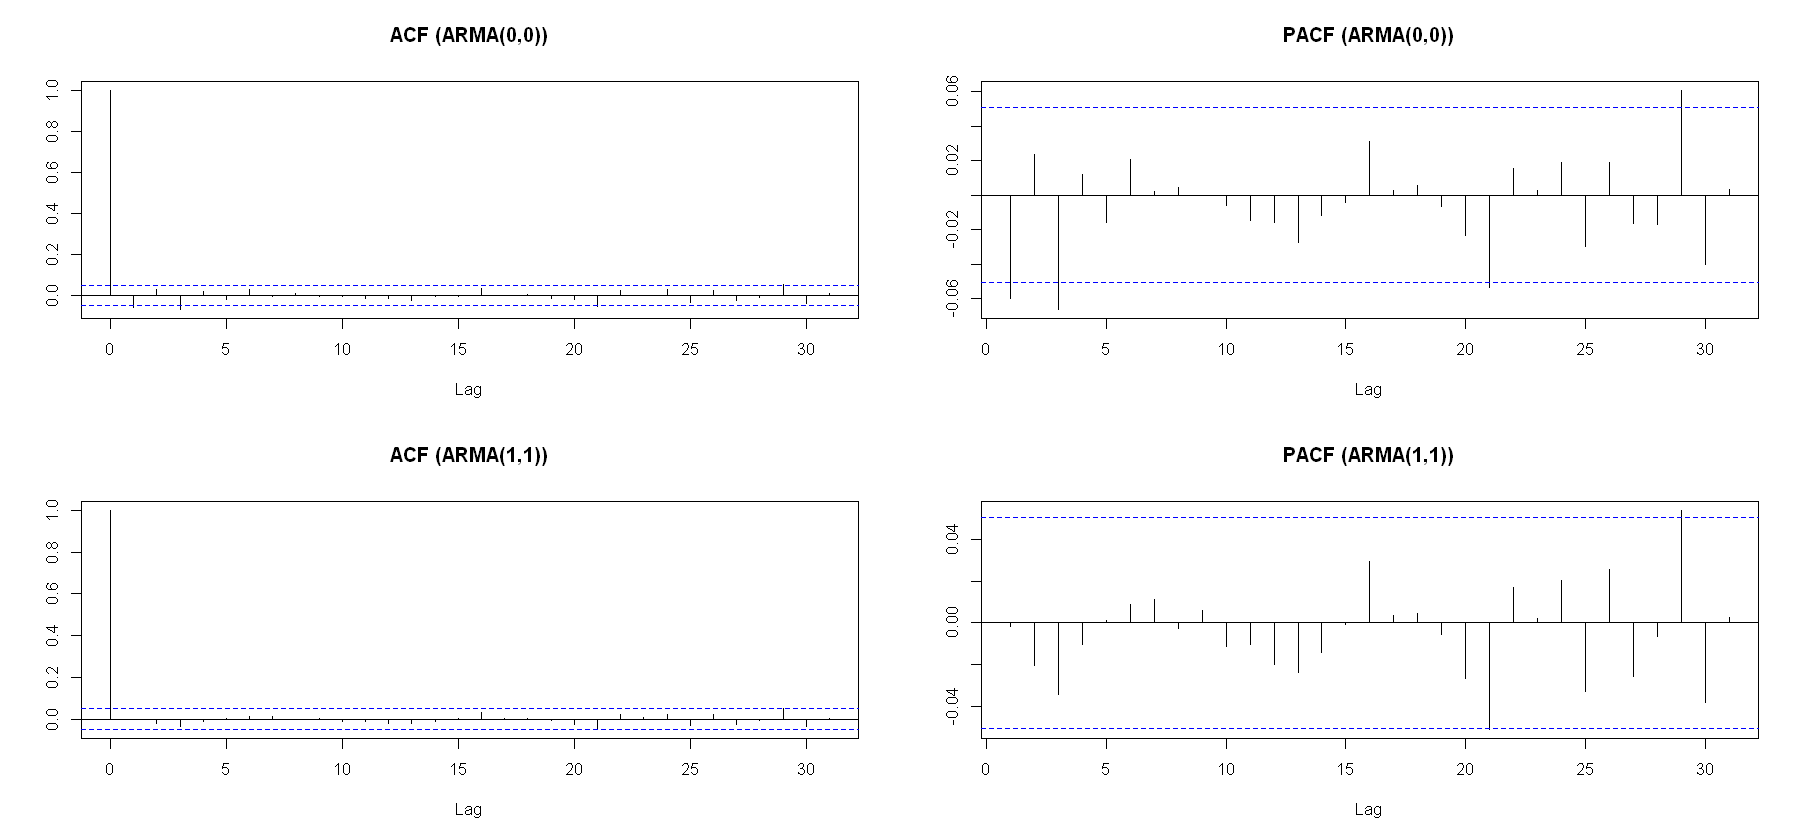

In [46]:
#Inspecting ACF and PACF of residuals
arma00 <- Arima(amzn$ret, order = c(0, 0, 0))
arma11 <- Arima(amzn$ret, order = c(1, 0, 1))
par(mfrow = c(2, 2))
acf(arma00$residuals, main = "ACF (ARMA(0,0))", ylab = "")
pacf(arma00$residuals, main = "PACF (ARMA(0,0))", ylab = "")
acf(arma11$residuals, main = "ACF (ARMA(1,1))", ylab = "")
pacf(arma11$residuals, main = "PACF (ARMA(1,1))", ylab = "")

As the PACF shows, the ARMA(1,1) model is successful in removing the dependencies. We can verify that by performing the Ljung-Box test.

In [47]:
#Ljung-Box test ARMA(0,0) residuals
for (lag_order in c(4, 8, 12)) {
  print(paste("ARMA(0,0) residuals, lag ", lag_order, ": ", Box.test(arma00$residuals, type = "Ljung-Box", lag = lag_order)$p.value, sep = ""), quote = F)
}
#Ljung-Box test ARMA(1,1) residuals
for (lag_order in c(4, 8, 12)) {
  print(paste("ARMA(1,1) residuals, lag ", lag_order, ": ", Box.test(arma11$residuals, type = "Ljung-Box", lag = lag_order)$p.value, sep = ""), quote = F)
}

[1] ARMA(0,0) residuals, lag 4: 0.00646114618524385
[1] ARMA(0,0) residuals, lag 8: 0.0398874570934957
[1] ARMA(0,0) residuals, lag 12: 0.153957636911634
[1] ARMA(1,1) residuals, lag 4: 0.634097864260056
[1] ARMA(1,1) residuals, lag 8: 0.937839917857175
[1] ARMA(1,1) residuals, lag 12: 0.984077529938079


The test rejects the null hypothesis of no autocorrelation in the ARMA(0,0) residuals for the 4th and 8th lag. On the other hand, the null hypothesis is not rejected for ARMA(1,1). Therefore, we will utilize ARMA(1,1) residuals for the GARCH estimation.

In [53]:
#ARMA(1,1)-GARCH(1,1) estimation
arma11_garch11spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), mean.model = list(armaOrder = c(1, 1)),
                                distribution.model = "std")
arma11_garch11_fit <- ugarchfit(arma11_garch11spec, amzn$ret)
arma11_garch11_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000983    0.000414   2.37709  0.01745
ar1    -0.533667    0.496284  -1.07533  0.28223
ma1     0.505971    0.507588   0.99681  0.31885
omega   0.000014    0.000000  29.62489  0.00000
alpha1  0.022055    0.001024  21.53492  0.00000
beta1   0.942773    0.006807 138.49648  0.00000
shape   3.809359    0.348976  10.91583  0.00000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000983    0.000391   2.51138 0.012026
ar1    -0.533667    0.510536  -1.04531 0.295881
ma1     0.505971    0.523515   0.96649 0.333800
omega   0.000014    0.000001  20.29468 0.000000
alpha1  0.022055    0.002108  10.46108 0.00

Following the basic practice, we estimated a GARCH(1,1) model. As we can see, neither the AR(1) nor the MA(1) term are significant. Since the specification tests does not find any dependence in the standardized residuals, the model performs well but may be overfitted. We will try estimating ARMA(0,0) and compare the results

In [54]:
#ARMA(0,0)-GARCH(1,1) estimation
arma00_garch11spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), mean.model = list(armaOrder = c(0, 0)),
                                    distribution.model = "std")
arma00_garch11_fit <- ugarchfit(arma00_garch11spec, amzn$ret)
arma00_garch11_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000961    0.000421   2.2847 0.022329
omega   0.000013    0.000000  48.0217 0.000000
alpha1  0.021046    0.001077  19.5474 0.000000
beta1   0.946893    0.005858 161.6508 0.000000
shape   3.797468    0.343692  11.0490 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000961    0.000390   2.4630 0.013777
omega   0.000013    0.000000  35.1609 0.000000
alpha1  0.021046    0.001613  13.0450 0.000000
beta1   0.946893    0.006471 146.3350 0.000000
shape   3.797468    0.423077   8.9758 0.000000

LogLikelihood : 3866.132 

Information Criteria
------------------------------------
                 

In this case, all the coefficients are statistically significant. In addition, the specification tests fail to find any dependencies. To decide between the two models, we will take a look at the PACF of the standardized residuals.

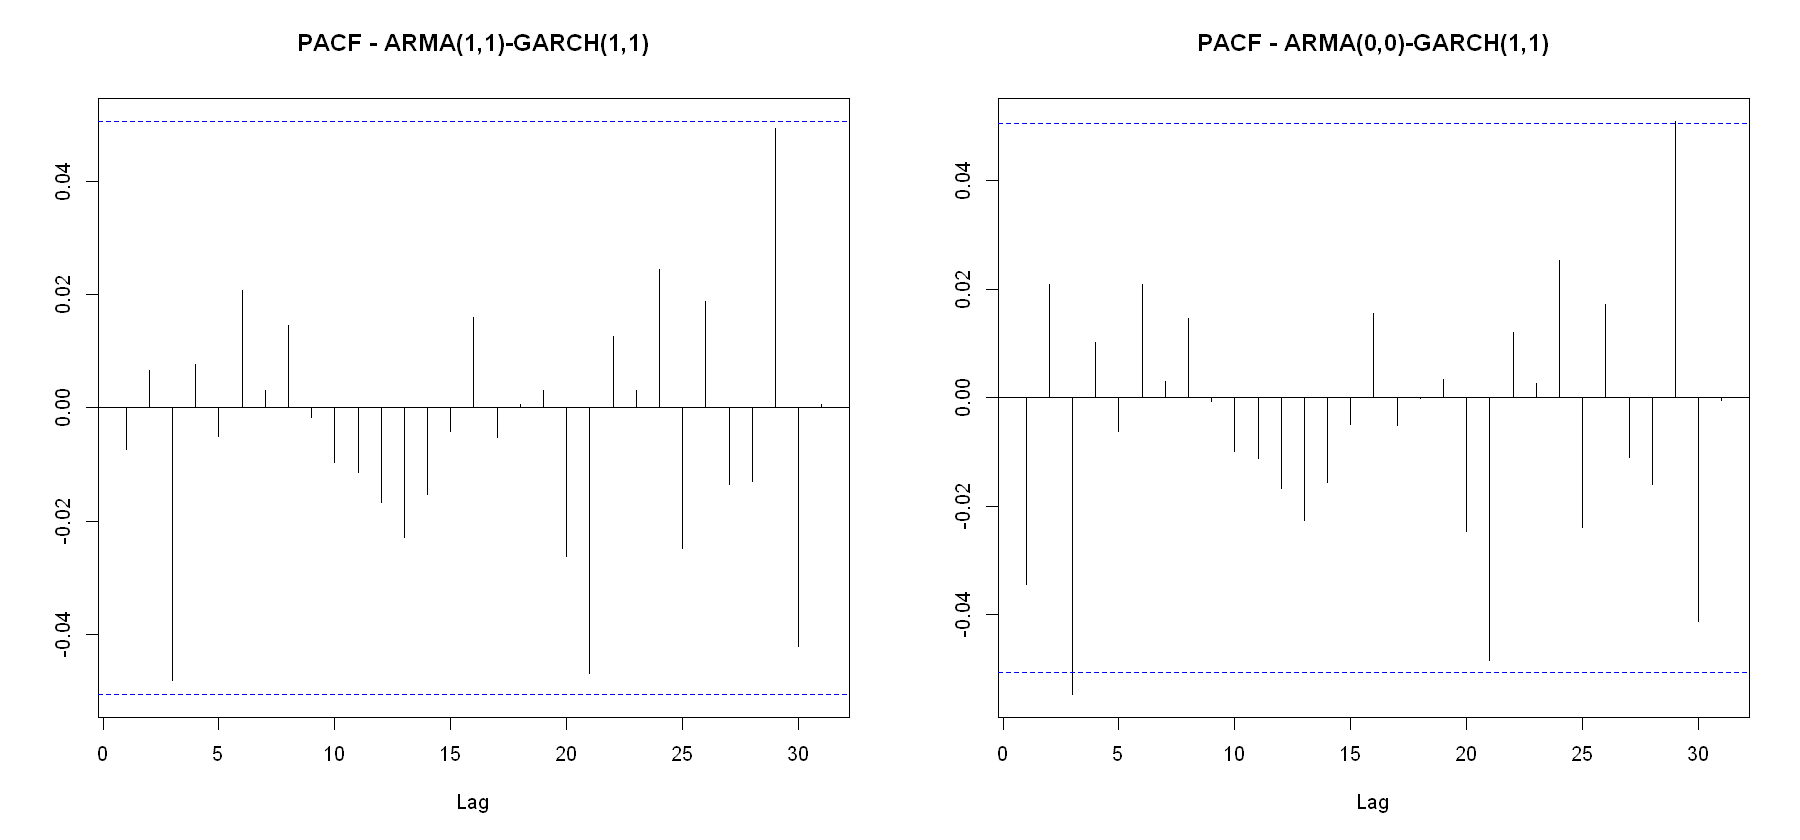

In [56]:
#PACF of standardized residuals
par(mfrow = c(1, 2))
pacf(residuals(arma11_garch11_fit, standardize = T), main = "PACF - ARMA(1,1)-GARCH(1,1)", ylab = "")
pacf(residuals(arma00_garch11_fit, standardize = T), main = "PACF - ARMA(0,0)-GARCH(1,1)", ylab = "")

From the PACF plot we can observe that while ARMA(1,1) is successful in removing all significant dependencies, the model with ARMA(0,0) is not. Even though the autocorrealtions are barely significant, we will select the ARMA(1,1) model since it is still reasonably parsimonious and we might avoid some convergence issues when forecasting. The plot of the fitted values follows.

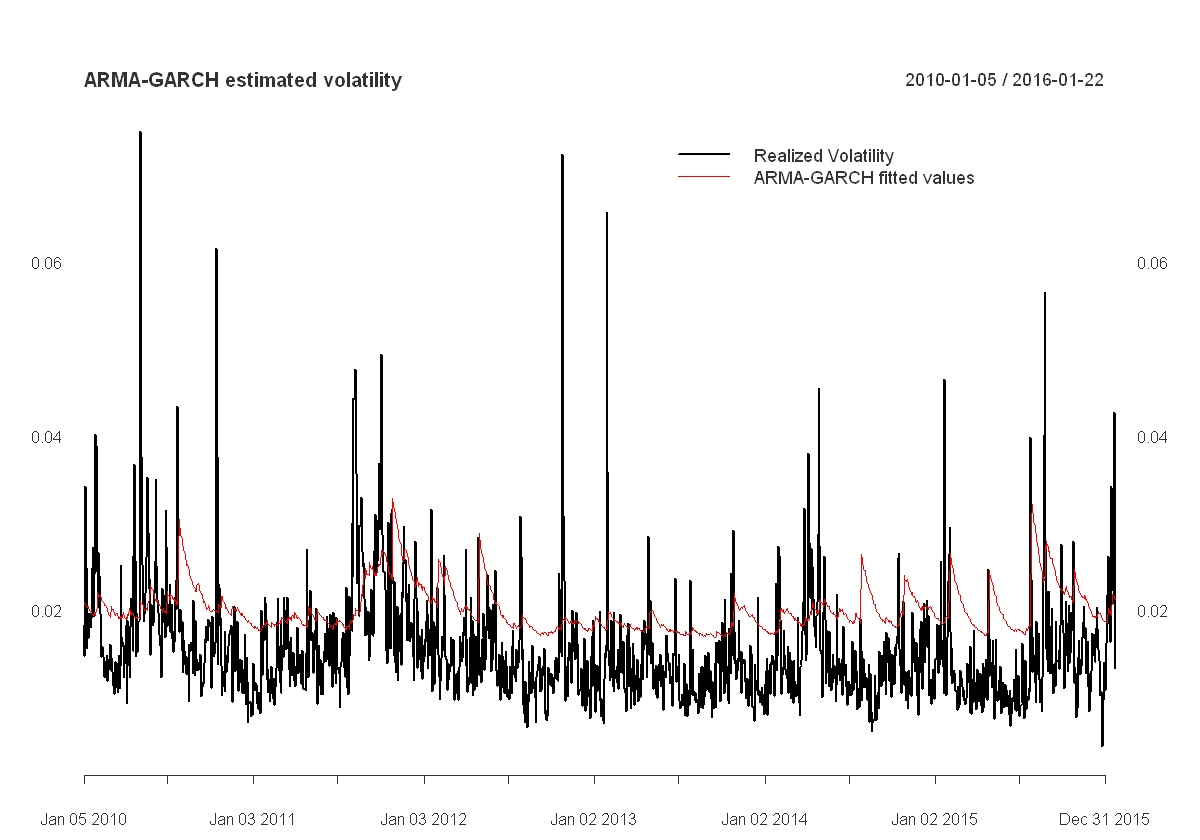

In [59]:
options(repr.plot.width = 10, repr.plot.height = 7)
#Plotting conditional volatility
arma_garch_fitted <- sigma(arma11_garch11_fit)
plot_holder <- plot(amzn$RV, main = "ARMA-GARCH estimated volatility", grid.col = NA)
plot_holder <- lines(arma_garch_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "ARMA-GARCH fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

According to the figure above, the ARMA-GARCH model heavily overestimates the Realized Volatility. It has likely the worst in-sample fit out of all the models in consideration.

#### In-sample fit comparison

Lastly, we will compare the in-sample fit of all models. As suggested, we plot the Realized Volatility together with the in-sample fits in one figure.

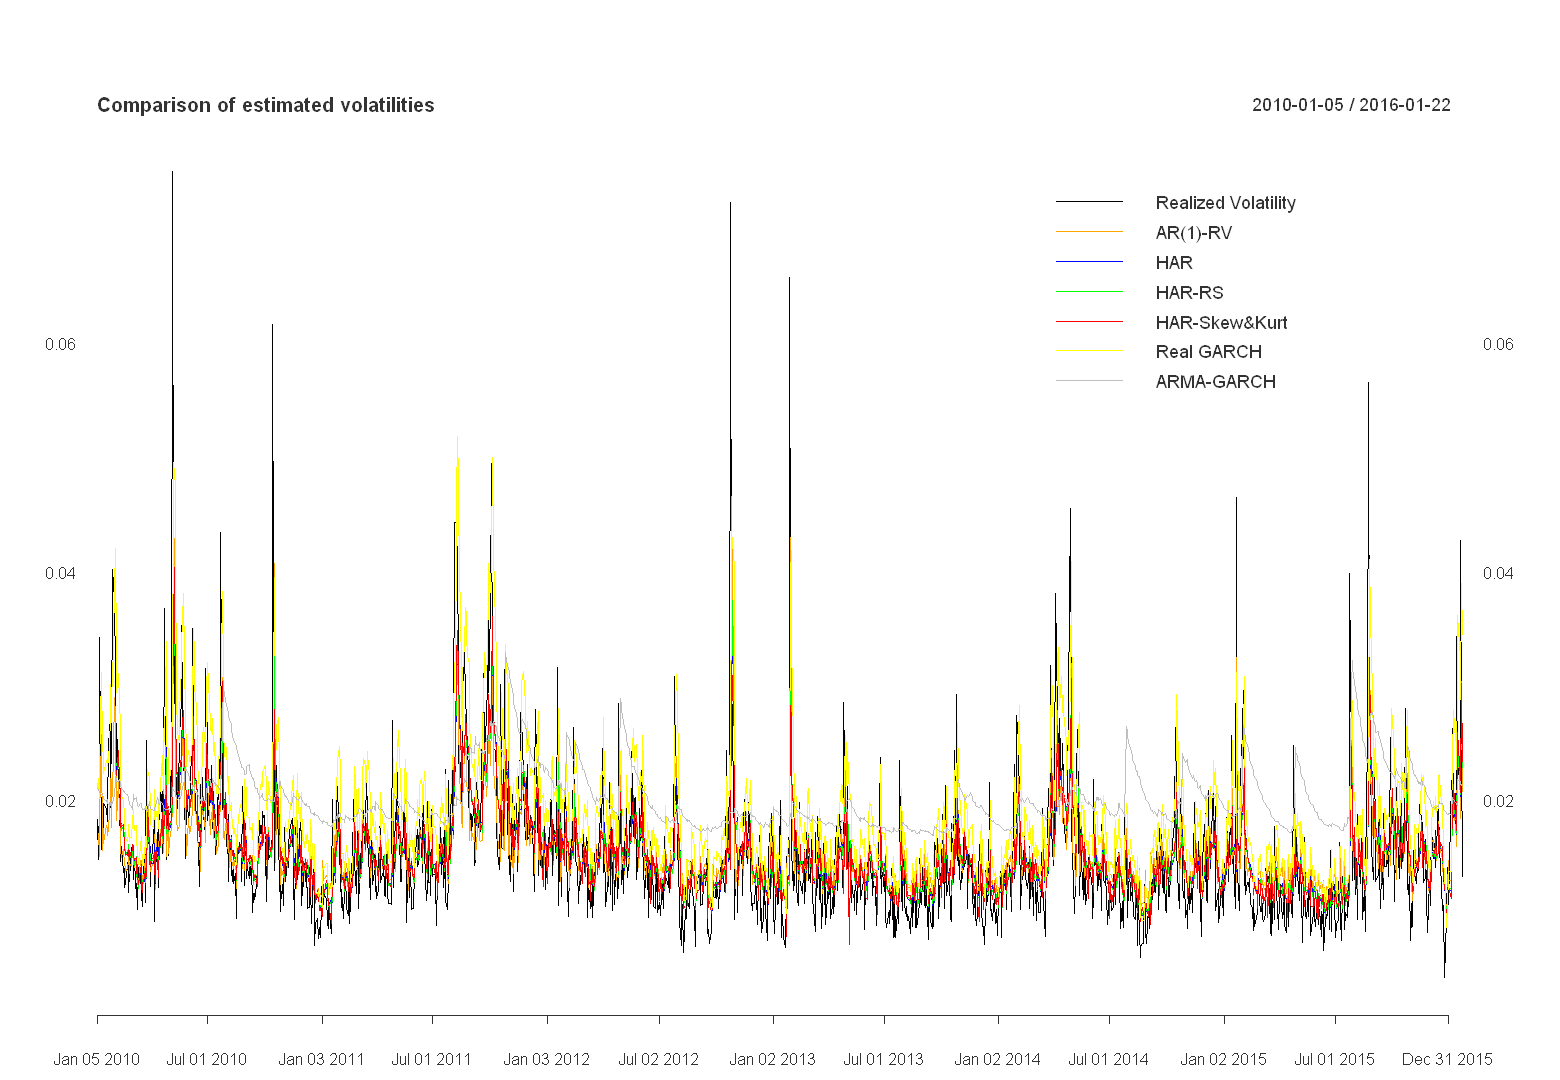

In [60]:
options(repr.plot.width = 13, repr.plot.height = 9)
#Plotting the estimated volatilities
plot_holder <- plot(amzn$RV, main = "Comparison of estimated volatilities", grid.col = NA, lwd = 1)
plot_holder <- lines(ar1_fitted, col = "orange")
plot_holder <- lines(har_fitted, col = "blue")
plot_holder <- lines(har_rs_fitted, col = "green")
plot_holder <- lines(har_skew_kurt_fitted, col = "red")
plot_holder <- lines(real_garch_fitted, col = "yellow")
plot_holder <- lines(arma_garch_fitted, col = "grey")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "AR(1)-RV", "HAR", "HAR-RS", "HAR-Skew&Kurt", "Real GARCH", "ARMA-GARCH"), col = c("black", "orange", "blue", "green", "red", "yellow", "grey"), lty = 1, bty = "n", lwd = 1)
plot_holder

As we suggested before, The HAR-type and AR(1)-RV models seem to have a better fit than the Real-GARCH and ARMA-GARCH, which tend to overfit the volatility. However, as the figure might be too cluttered and not very informative, we decided to compare the fits in more detail. We will do so by calculating the errors of all models and ploting their absolute values, and additionaly calculating the MAE and MSE statistics.

In [61]:
#Calculating the absolute errors
insample_errors <- vector("list", 6) #Empty vector for the results
fitted_values <- list(ar1_fitted, har_fitted, har_rs_fitted, har_skew_kurt_fitted, real_garch_fitted, arma_garch_fitted)
for (i in 1:6) { #Looping through the models
  insample_errors[[i]] <- abs(amzn$RV[index(fitted_values[[i]])] - fitted_values[[i]])
}

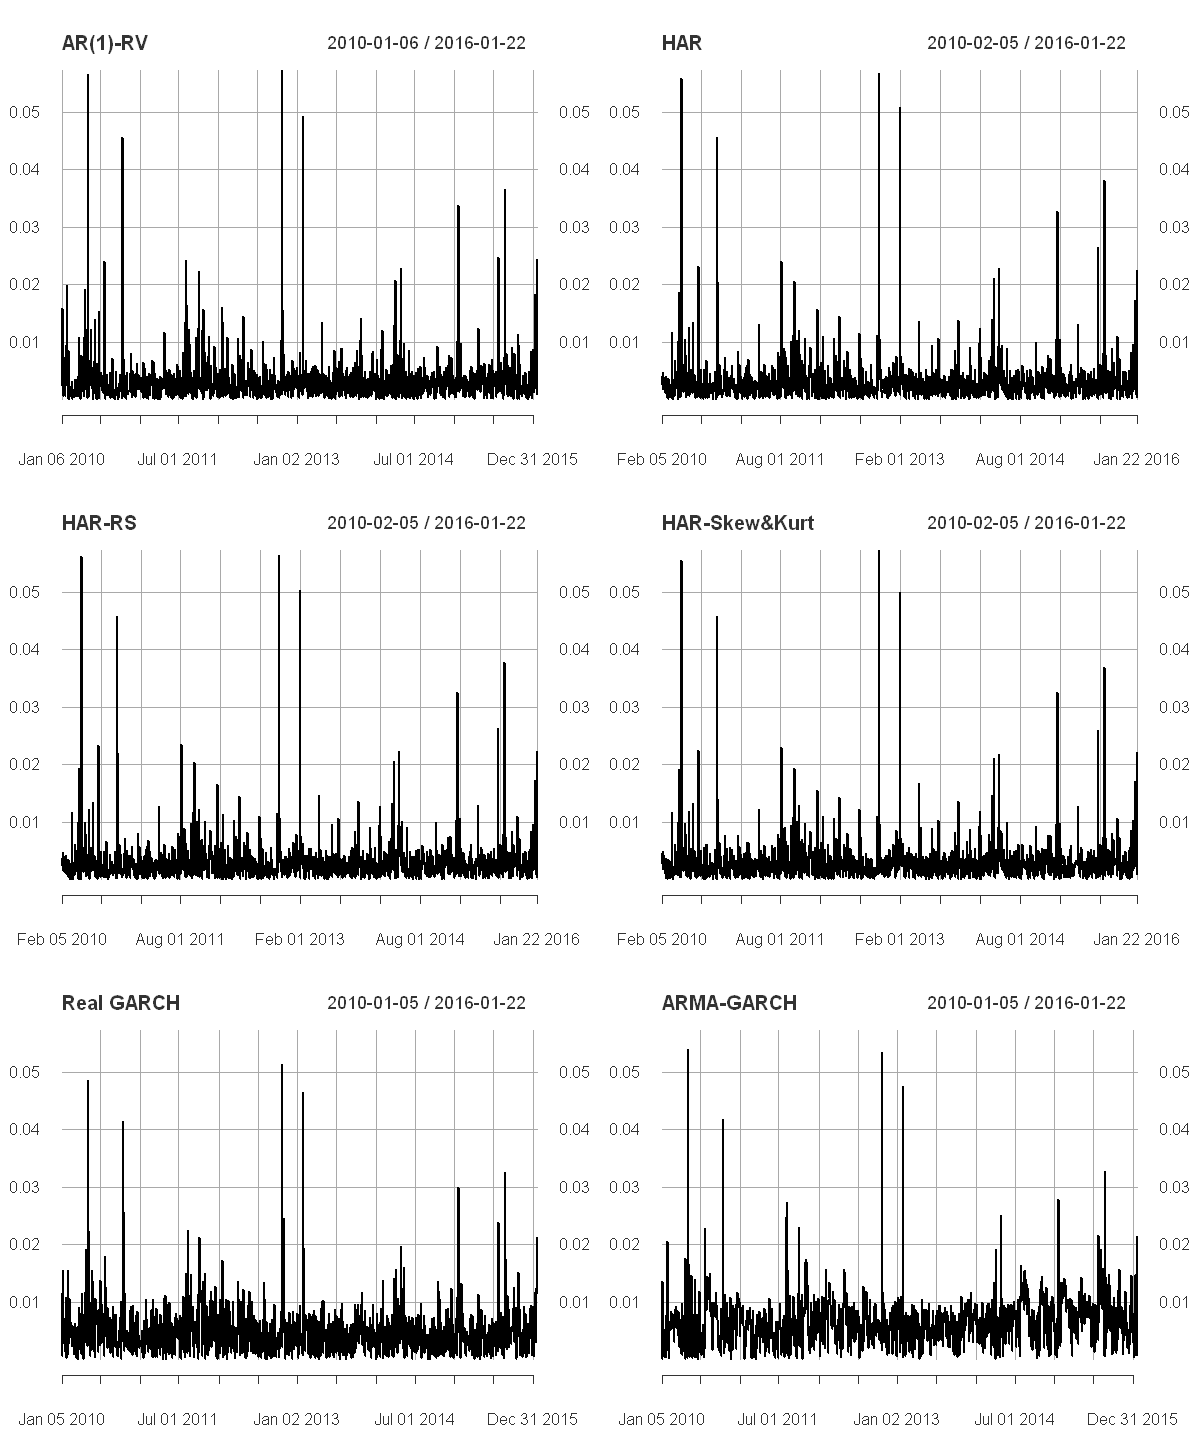

In [62]:
#Plotting the errors
options(repr.plot.width = 10, repr.plot.height = 12)
model_names <- c("AR(1)-RV", "HAR", "HAR-RS", "HAR-Skew&Kurt", "Real GARCH", "ARMA-GARCH") #Defining model names
par(mfrow = c(3, 2))
for (i in 1:6) {
  print(plot(insample_errors[[i]], ylim = c(min(insample_errors[[1]]), max(insample_errors[[1]])), main = model_names[i]))
}

Even though the differences are not that large, we can clearly see that the HAR-type models appear to be superior to GARCH-type models. The ARMA-GARCH model generates the largest absolute errors and thus provides the poorest predictions out of all the models in consideration. To get a more precise insight, we can calculate the mean of the absolute and squared errors.

In [64]:
#Mean of absolute and squared errors
insample_MAE <- unlist(lapply(insample_errors, mean)) #computing MAE
insample_errors_squared <- lapply(insample_errors, function(x) x ^ 2) #computing squared errors
insample_MSE <- unlist(lapply(insample_errors_squared, mean)) #computing MSE

#Ordering MAE by size
MAE_order <- matrix(insample_MAE) #creating unordered matrix with values and model names
row.names(MAE_order) <- model_names
MAE_order <- MAE_order[order(MAE_order[,1]),] #ordering
MAE_mat <- matrix(MAE_order) #recreating a matrix with ordered values and names
row.names(MAE_mat) <- names(MAE_order)
colnames(MAE_mat) <- "MAE"

MAE_mat

,MAE
HAR-Skew&Kurt,0.003131765
HAR-RS,0.003145712
HAR,0.003168011
AR(1)-RV,0.003349255
Real GARCH,0.004890475
ARMA-GARCH,0.006557167


In [65]:
#Ordering MSE by size
MSE_order <- matrix(insample_MSE) #creating unordered matrix with values and model names
row.names(MSE_order) <- model_names
MSE_order <- MSE_order[order(MSE_order[,1]),] #ordering
MSE_mat <- matrix(MSE_order) #recreating matrix with ordered values and names
row.names(MSE_mat) <- names(MSE_order)
colnames(MSE_mat) <- "MSE"

MSE_mat

,MSE
HAR-Skew&Kurt,2.569684e-05
HAR-RS,2.612022e-05
HAR,2.635347e-05
AR(1)-RV,2.843849e-05
Real GARCH,4.244949e-05
ARMA-GARCH,6.313485e-05


As we can see, the values of the Mean Absolute Error (MAE) and Mean Squared Error (MSE) confirm our observations. The HAR-type models appear to have the greatest fit since the values of MAE and MSE are the lowest, while in case of GARCH-type models they are much higher, indicating poor a fit.

### 3. Forecasts

In this section we will perform forecasting using the models introduced in the previous section. For each model we will perform a one step ahead forecast using an expanding window and a rolling window. The expanding window starts at 750 observations and the size of the rolling window is 750 as well. Therefore, since the number of observations in the data set is 1500, we will get 750 forecasts.

Since the estimation procedure is similar for the first four models, we will define a function to facilitate the process and avoid recopying the code. We will also store all the forecasts in a single list for easier manipulation. Since the process is quite time demanding, the following steps can be skipped and an already forecasted data set can be loaded.

In [109]:
#Initiating a vector for storing the forecasts
forecasts <- vector("list", 6) #For 6 models

In [110]:
#Defining a function for forecasting HAR-type models
forecast_lm <- function(form, xts_object = amzn, wind_len = 750, roll = F) { #Forecast based on a dataset, model formula, length of the window and either rolling or expanding
  result <- xts(rep(NA, nrow(xts_object)-wind_len), order.by = index(xts_object)[(wind_len + 1):nrow(xts_object)]) #Empty xts object for the results (predicting 751-1500)
  if (roll == T) { #Rolling window
    for (i in 1:(nrow(xts_object)-wind_len)) { #Looping through the rolled windows
      model <- lm(form, data = xts_object[i:(wind_len-1+i)]) #Estimating the model on the window (1-750, 2-751...)
      result[i] <- predict(model, newdata = xts_object[wind_len + i]) #Forecasting
    }
    } else { #Expanding window
    for (i in wind_len:(nrow(xts_object) - 1)) { #Looping through the windows (750-1499)
      model <- lm(form, data = xts_object[1:i]) #Estimating the model on the window
      result[i - wind_len + 1] <- predict(model, newdata = xts_object[i + 1]) #Forecasting
    }
    }
  return(result)
}

Now we will specify the formulas for the first four models and apply the function above on the provided data set.

In [111]:
#Defining the formulas for first four models
formulas <- c("RV ~ RV_lag", "RV ~ RV_lag + RV_5 + RV_22", "RV ~ RV_p_lag + RV_n_lag + RV_5 + RV_22",
              "RV ~ RV_lag + RV_5 + RV_22 + RS_lag + RK_lag")

#Looping through the first four models 
for (i in 1:4) {
  #For each model forecast with expanding window and rolling window and merge the resulting series together and store the result in a list
  forecasts[[i]] <-  merge.xts(forecast_lm(formulas[i]), forecast_lm(formulas[i], roll = T))
  names(forecasts[[i]]) <- paste(rep(model_names[i], 2), c("exp", "roll"), sep = "_") #Name the columns for clarity
}

Next, we will perform a similar procedure for the remaining two GARCH-type models. We specify the option ``solver="hybrid"`` since otherwise the model fails to converge in some cases.

In [112]:
#Defining a function to forecast GARCH type models
forecast_garch <- function(specif, xts_object = amzn$ret, realizedVol = amzn$RV, wind_len = 750, roll = F) {
  result <- xts(rep(NA, nrow(xts_object)-wind_len), order.by = index(xts_object)[(wind_len + 1):nrow(xts_object)]) #Empty xts object for the results (predicting 751-1500)
  if (roll == T) { #Rolling window
    for (i in 1:(nrow(xts_object)-wind_len)) { #Looping through the rolled windows
      model <- ugarchfit(specif, xts_object[i:(wind_len-1+i)], realizedVol = realizedVol[i:(wind_len-1+i)], solver = "hybrid") #Fitting the model, hybrid solver to prevent convergence failure
      result[i] <- as.numeric(ugarchforecast(model, n.ahead = 1)@forecast$sigmaFor) #Producing the 1 step ahead forecast
    }
  } else { #Expanding window
    for (i in wind_len:(nrow(xts_object) - 1)) { #Looping through the windows (750-1499)
      model <- ugarchfit(specif, xts_object[1:i], realizedVol = realizedVol[1:i], solver = "hybrid") #Estimating the model on the window, hybrid solver to prevent convergence failure
      result[i - wind_len + 1] <- as.numeric(ugarchforecast(model, n.ahead = 1)@forecast$sigmaFor) #Producing the 1 step ahead forecast
    }
  }
  return(result)
}

In [ ]:
#Looping through the last two (GARCH type) models
specs <- list(real_garchspec, arma11_garch11spec) #Storing the specifications for looping
for (i in 1:2) {
  forecasts[[i + 4]] <- merge.xts(forecast_garch(specs[[i]]), forecast_garch(specs[[i]], roll = T))
  names(forecasts[[i + 4]]) <- paste(rep(model_names[i + 4], 2), c("exp", "roll"), sep = "_") #Name the columns for clarity
}

Since the procedure is very time demanding, we also provide and option to load already calculated forecasts.

In [66]:
#Load saved forecasts
load("forecasts.RData")

Now that the forecasts are estimated, we can take a look at their summary to check for any inconsistencies.

In [67]:
#Inspecting the forecasts
for (i in 1:6) {
  print(summary(forecasts[[i]]))
}

     Index             AR(1)-RV_exp      AR(1)-RV_roll     
 Min.   :2013-01-11   Min.   :0.009475   Min.   :0.009516  
 1st Qu.:2013-10-10   1st Qu.:0.013111   1st Qu.:0.012810  
 Median :2014-07-14   Median :0.014372   Median :0.013999  
 Mean   :2014-07-14   Mean   :0.014990   Mean   :0.014560  
 3rd Qu.:2015-04-14   3rd Qu.:0.015799   3rd Qu.:0.015389  
 Max.   :2016-01-22   Max.   :0.044064   Max.   :0.044248  
     Index               HAR_exp           HAR_roll       
 Min.   :2013-01-11   Min.   :0.00961   Min.   :0.009638  
 1st Qu.:2013-10-10   1st Qu.:0.01250   1st Qu.:0.012435  
 Median :2014-07-14   Median :0.01386   Median :0.013742  
 Mean   :2014-07-14   Mean   :0.01445   Mean   :0.014312  
 3rd Qu.:2015-04-14   3rd Qu.:0.01553   3rd Qu.:0.015261  
 Max.   :2016-01-22   Max.   :0.03579   Max.   :0.035793  
     Index              HAR-RS_exp        HAR-RS_roll     
 Min.   :2013-01-11   Min.   :0.009544   Min.   :0.00958  
 1st Qu.:2013-10-10   1st Qu.:0.012471   1st Qu.:

As we can see, most of the forecasts seem fairly reasonable. However, the exception is the Realized GARCH. The maximum value forecasted by this model is unreasonably high for the expanding window scheme. As mentioned above, we have encountered some convergence issues and the result might be unreasonable forecasts. In order to be able to compare the performance of the models, we will perform truncation on the results of the Realized GARCH. For the remaining models, the median appears to be reasonably close to the mean and therefore, we deem the results reliable.

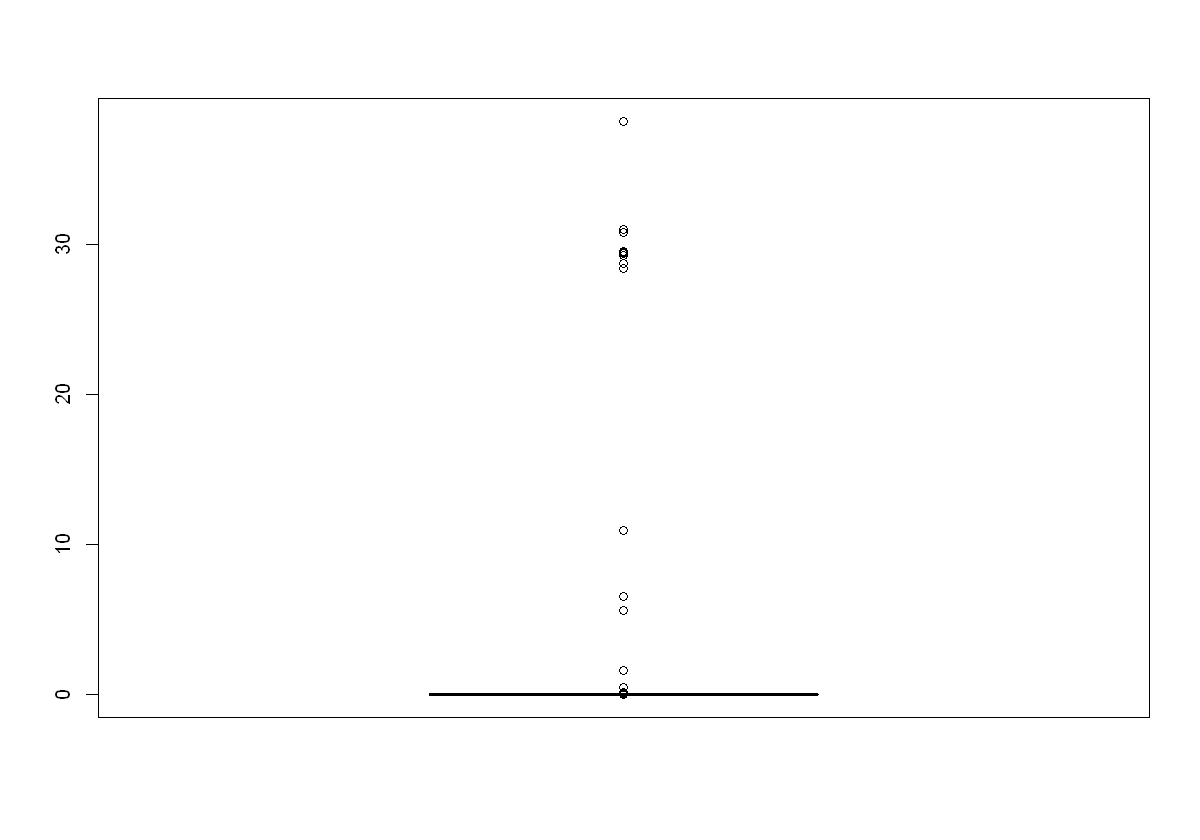

In [68]:
options(repr.plot.width = 10, repr.plot.height = 7)
#Inspecting the outliers of Realized GARCH
boxplot(forecasts[[5]][, 1]) #Extreme outliers

As the boxplot above demonstrates, the forecasts from Realized GARCH suffer from many extreme observations. Therefore, we will perform truncation.

In [69]:
#Truncation 97.5 percentile
thres <- quantile(forecasts[[5]][, 1], probs = 0.975)
forecasts[[5]][forecasts[[5]][, 1] > thres, 1] <- NA #Disregarding values higher than 97.5 percentile

In [70]:
#Summary again
summary(forecasts[[5]][, 1])

     Index            Real GARCH_exp    
 Min.   :2013-01-11   Min.   :0.005070  
 1st Qu.:2013-10-10   1st Qu.:0.008098  
 Median :2014-07-14   Median :0.009483  
 Mean   :2014-07-14   Mean   :0.010505  
 3rd Qu.:2015-04-14   3rd Qu.:0.011332  
 Max.   :2016-01-22   Max.   :0.056231  
                      NA's   :19        

The values appear to be more reasonable now. The mean and median are now much closer to each other. We can see that we disregarded only 19 observations. Therefore, the number of observations should still be sufficient to compare the models' performance. We will start by calculating and plotting the errors.

In [71]:
#Defining a function to calculate the errors
calc_errors <- function(xts_object) { #Expects and xts object with two columns (extending and rolling window)
  first_col <- amzn$RV[index(xts_object)] - xts_object[, 1] #True RV - forecasted RV
  second_col <- amzn$RV[index(xts_object)] - xts_object[, 2] #True RV - forecasted RV
  result <- merge.xts(first_col, second_col) #Merge the columns together
  names(result) <- paste(names(xts_object), "error", sep = "_") #Rename the columns for clarity
  return(result) #Return an xts object with two columns containing the errors
}

In [72]:
#Applying the function
forecast_errors <- lapply(forecasts, calc_errors)

The plot of the errors follows.

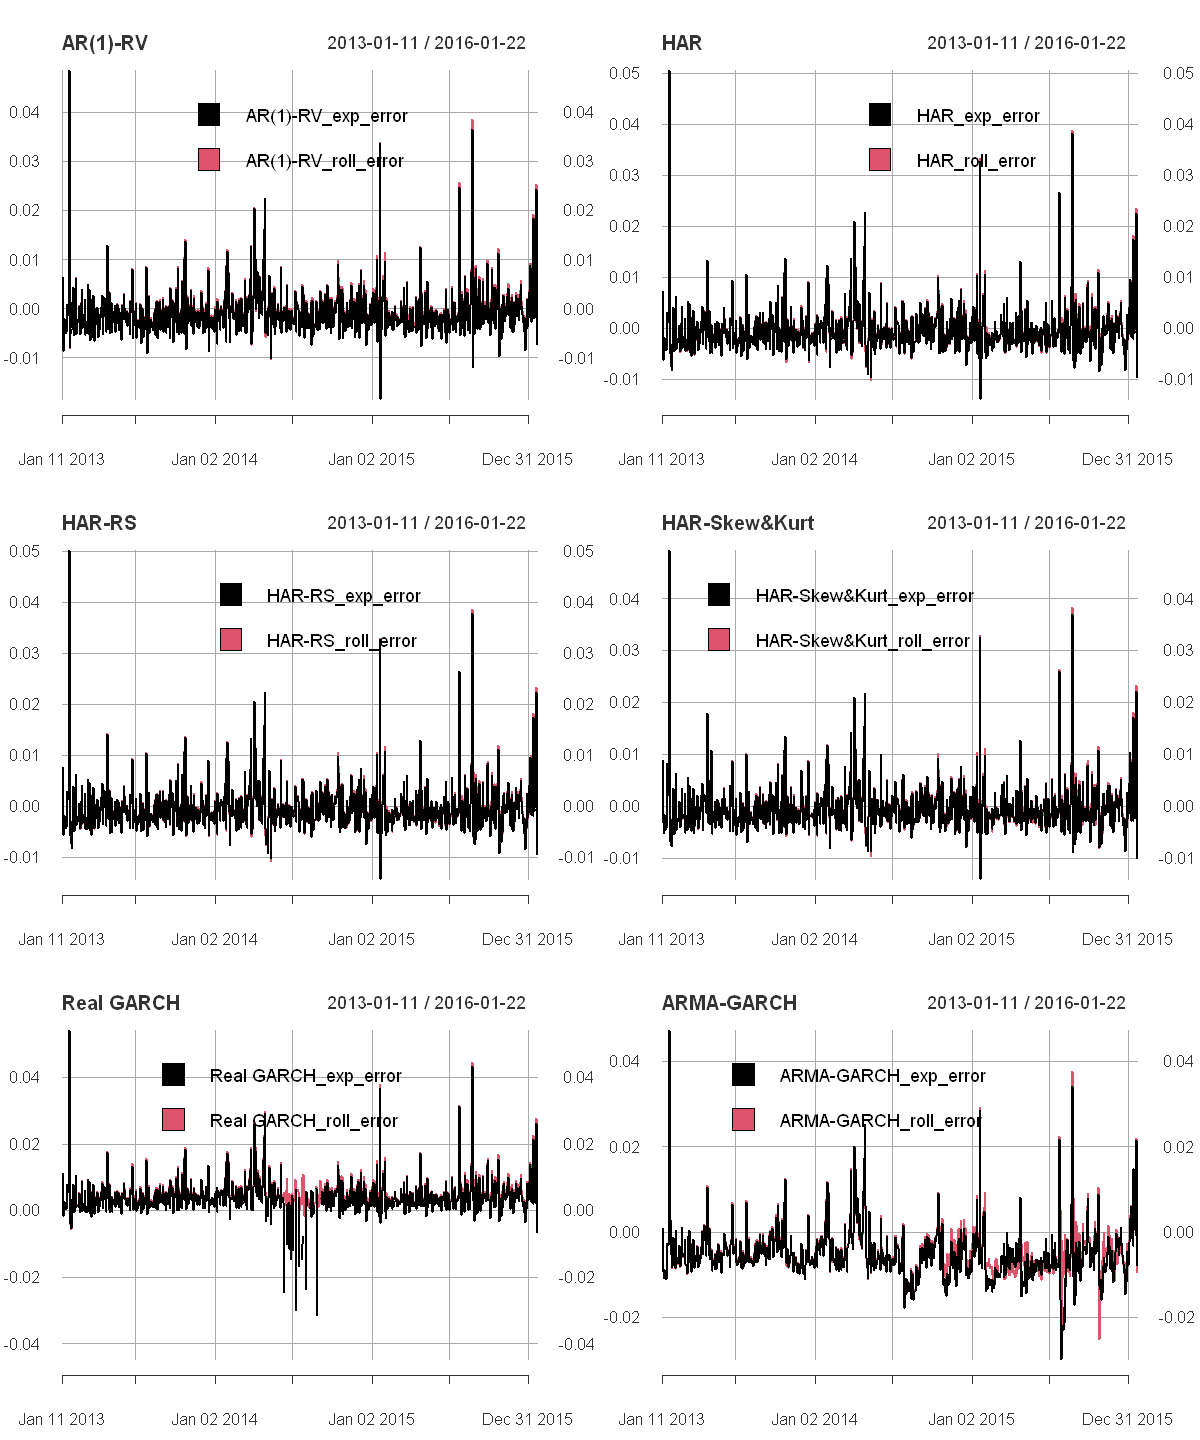

In [73]:
options(repr.plot.width = 10, repr.plot.height = 12)
#Plotting forecast errors
par(mfrow = c(3,2))
for (i in 1:6) {
  print(plot(forecast_errors[[i]], main = model_names[i], legend.loc = "topright"))
}

From the figure above we can observe that for HAR-type models, there is not much of difference between the rolling and expanding window. On the other hand, the Realized GARCH with an expanding window seems to produce some unusually high forecasts in the middle of the forecasted period. These may still be the remnants of the convergence issues. In addition, for the ARMA-GARCH model, the two schemes seem to produce systematically different forecasts in the second half of the forecasted period. This may suggest a presence of a structural break. Let us now inspect the results more thoroughly by calculating the loss functions Mean Squarred Error (MSE) and Mean Absolute Error (MAE).

In [74]:
#Defining a function for MSE and MAE
calc_loss <- function(xts_object, loss_func = "MSE") {
  res_names <- paste(names(xts_object), loss_func, sep = "_") #Creating names for the resulting xts_object
  if (loss_func == "MSE") { #MSE
    result <- xts_object^2 #Errors squared
  } else if (loss_func == "MAE") { #MAE
    result <- abs(xts_object) #Absolute value of errors
  } else {
    stop("Invalid loss function")
  }
    names(result) <- res_names
    return(result)
}

In [75]:
#Applying the function
MSE <- do.call(merge.xts, lapply(forecast_errors, calc_loss)) #MSE
MAE <- do.call(merge.xts, lapply(forecast_errors, calc_loss, loss_func = "MAE")) #MAE

A direct comparison of forecasting perfomance can be achieved by analyzing the means of the loss functions.

In [77]:
#Calculating mean MSE and MAE
MSE_mean <- sort(apply(MSE, 2, mean, na.rm = T))
MAE_mean <- sort(apply(MAE, 2, mean, na.rm = T))
MSE_mean_mat <- matrix(MSE_mean, ncol = 1)
MAE_mean_mat <- matrix(MAE_mean, ncol = 1)
row.names(MSE_mean_mat) <- names(MSE_mean)
row.names(MAE_mean_mat) <- names(MAE_mean)
MSE_mean_mat*100 #Multiplying by 100 for illustrative purposes
MAE_mean_mat

HAR.RS_exp_error_MSE,0.002302701
HAR.RS_roll_error_MSE,0.002304141
HAR_roll_error_MSE,0.002315622
HAR_exp_error_MSE,0.002316280
HAR.Skew.Kurt_exp_error_MSE,0.002322474
HAR.Skew.Kurt_roll_error_MSE,0.002338222
AR.1..RV_roll_error_MSE,0.002402683
AR.1..RV_exp_error_MSE,0.002450870
Real.GARCH_roll_error_MSE,0.004742283
Real.GARCH_exp_error_MSE,0.005111120
ARMA.GARCH_roll_error_MSE,0.005313624


HAR.RS_roll_error_MAE,0.003071247
HAR_roll_error_MAE,0.003073258
HAR_exp_error_MAE,0.003098114
HAR.RS_exp_error_MAE,0.003100116
HAR.Skew.Kurt_roll_error_MAE,0.003114278
HAR.Skew.Kurt_exp_error_MAE,0.003132319
AR.1..RV_roll_error_MAE,0.003205780
AR.1..RV_exp_error_MAE,0.003339676
Real.GARCH_exp_error_MAE,0.004866513
Real.GARCH_roll_error_MAE,0.005019468
ARMA.GARCH_roll_error_MAE,0.005950572


As the table above shows, the HAR model with Realized Semi-Volatilities has the lowest MSE for the expanding window and also the lowest MAE for the rolling window. We can also see that the GARCH models perform worse than the HAR models according to both measurements. As another means fo comparison we will use the Diebold-Mariano test utilizing the MSE loss function. We will compare all pairs of models and assess whether the first model statistically performs better than the second one. If so, we will assign a point.

In [78]:
#Diebold-Mariano test
dm_test_points <- matrix(rep(0, 12), nrow = 12) #Empty matrix to store the number of times a model is more accurate than another model
row.names(dm_test_points) <- names(MSE) #Naming for clarity
for (i in 1:12) { #Looping through the columns of MSE
  for (j in 1:12) { #For each column calculate DM test with all other columns
    if (i==j) { #Skip an iteration to prevent testing of a model against itself
      next
    } else {
      test_result <- dm.test(na.omit(MSE[, i]), na.omit(MSE[, j]), alternative = "less")
      dm_test_points[i, ] <- ifelse(test_result$p.value <= 0.05, dm_test_points[i, ] + 1, dm_test_points[i, ])
    }
  }
}
as.matrix(dm_test_points[order(dm_test_points[, 1], decreasing = T), ]) #Sorting from the highest to lowest

AR.1..RV_exp_error_MSE,4
AR.1..RV_roll_error_MSE,3
HAR.RS_exp_error_MSE,3
HAR.Skew.Kurt_exp_error_MSE,3
HAR.Skew.Kurt_roll_error_MSE,3
HAR_exp_error_MSE,2
HAR_roll_error_MSE,2
HAR.RS_roll_error_MSE,2
ARMA.GARCH_roll_error_MSE,2
ARMA.GARCH_exp_error_MSE,1
Real.GARCH_exp_error_MSE,0


According to the Diebold-Mariano test, the AR(1) model outperforms 4 other models and is thus the best performing model in this regard. The GARCH-type models are still the worst performing even according to this metric.

Lastly, we will compare the models using the Minzer-Zarnowitz regression. For each model, we will regress the actual values of Realized Volatility on the forecasts and test the following hypotheses:
$$
H_0:\alpha=0,\ H_a:\alpha\neq 0 \\
H_0:\beta=1,\ H_a:\beta\neq 1,
$$
in a regression:
$$
RV_t = \alpha + \beta\widehat{RV_t} + \epsilon_t
$$
If we fail to reject both hypotheses, the model passes the assumptions and provides satisfying forecasts. In case we reject one or both hypotheses, the forecast are likely systematically biased.

In [79]:
#Mincer-Zarnowitz regression
forecasts_merged <- do.call(merge.xts, forecasts) #Merging the forecasts into a single xts object
MZ_results <- matrix(nrow = 12) #Empty matrix for the results of MZ test
row.names(MZ_results) <- names(forecasts_merged)
for (i in 1:12) { #For each model
  mz_model <- lm(amzn$RV[index(forecasts_merged)] ~ forecasts_merged[, i]) #Estimate the model
  mz_model_sum <- summary(mz_model) #Save the summary
  indic1 <- mz_model_sum$coefficients[1, 4] > 0.05 #Check that intercept is not significantly different from zero
  indic2 <- abs((mz_model_sum$coefficients[2, 1] - 1)/mz_model_sum$coefficients[2, 2]) < 1.96 #Check that the coef is not different from 1
  MZ_results[i, ] <- ifelse(indic1 & indic2, T, F)
}
MZ_results

AR.1..RV_exp,FALSE
AR.1..RV_roll,TRUE
HAR_exp,TRUE
HAR_roll,TRUE
HAR.RS_exp,TRUE
HAR.RS_roll,TRUE
HAR.Skew.Kurt_exp,FALSE
HAR.Skew.Kurt_roll,TRUE
Real.GARCH_exp,FALSE
Real.GARCH_roll,FALSE
ARMA.GARCH_exp,FALSE


The results mostly confirm the previous findings. For both of the GARCH-type models we reject at least one hypothesis. On the other hand, only two of the HAR-type models do not pass the assumptions and only for the expanding window.

### 4. Summary

To conclude, we estimated the volatility of returns on the stock of Amazon, using daily price data between January 5, 2010, and January 22, 2016, resulting in 1500 observations. We employed six models in total, including the AR(1)-Realized Volatility, HAR, HAR-Realized Semivolatility, HAR-Realized Skewness and Kurtosis, Realized-GARCH, and ARMA-GARCH. According to information criteria, specification tests, and best practices, we used Real-GARCH(1,1) and ARMA(1,1)-GARCH(1,1) specifications of the models.

We estimated the in-sample fit, utilizing the full sample size, and compared the fitted values with the Realized Volatility, which served as a proxy for the true volatility. Overall, all models tend to overestimate the volatility, and occasionally fail to capture large jumps. However, the first four models (AR(1)-RV and HAR-type models) estimated the volatility closer to the Realized Volatility than the GARCH-type models, which overestimated strongly. This was also confirmed by the Mean Absolute Error and Mean Squared Error statistics. Even though the differences in the group of the first four models were only marginal, the best fit seems to be reached by the HAR-Realized Skewness and Kurtosis model. On the other hand, the ARMA-GARCH model fits the volatility the worst of all models, notably worse than the Real-GARCH model.

Further, we derived on-step-ahead forecasts of volatility for all models, using the rolling and expanding window forecasting schemes. Again, the Realized Volatility served as a proxy for the true volatility while evaluating the forecasts. For the evaluation, the MAE and MSE loss functions, Diebold-Mariano test, and Minzer-Zarnowitz regression were used. In the case of the first four models, there is close to no difference in forecasted values when comparing rolling and expanding window regimes. On the other hand, the Real-GARCH produced very different forecasts between the two schemes in the middle of the forecasted period. As for the ARMA-GARCH model, the differences between the expanding and rolling window are quite pronounced in the second part of the forecasted period. Results of the loss functions suggest, similarly to the in-sample estimation, that the best performing models are from the HAR-group, the very best being the HAR model with Realized Semi-Volatilities, either under expanding scheme (MAE) or under rolling scheme (MSE). On the contrary, in line with expectations, the GARCH models tend to perform the worst according to the loss functions. The DM test suggests the AR(1)-RV model with expanding window being the best performing, closely followed by the expanding HAR-RS model. Again, GARCH models seem like the worse option. MZ regression yields similar insights, suggesting that expanding AR(1)-RV, expanding HAR-Skew&Kurt and all GARCH models are likely to systematically over-predict or under-predict the volatility.

Overall, the best performing seems to be the HAR-RS model, closely followed by other HAR-type models, especially with the rolling window forecasting scheme.